[View in Colaboratory](https://colab.research.google.com/github/HeshamMahrous/python-acoustics/blob/master/Hesham_Mahrous.ipynb)

# Instructions

This is an imperfect implementation of ResNet configured to train with the CIFAR-10 dataset.

There are a few bugs and it should be able to reach a higher accuracy. See what you can do to fix it and write a few paragraphs about what you did.

# Imports

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import time
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import files

print('TensorFlow Version:', tf.VERSION)
print('TensorFlow GPU:', tf.test.gpu_device_name())

TensorFlow Version: 1.9.0
TensorFlow GPU: /device:GPU:0


# Data

In [4]:
data_name = 'cifar-10-batches-bin'
data_dir = os.path.join('/content/.keras/datasets', data_name)
data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
tf.keras.utils.get_file(data_name, data_url, untar=True)

136372224/170052171 [=======================>......] - ETA: 10s

170065920/170052171 [==============================] - 53s 0us/step


'/content/.keras/datasets/cifar-10-batches-bin'

# Inputs

In [0]:
def get_input_fn(filenames, batch_size, num_epochs, shuffle=False, augment=False):
    label_bytes = 1
    image_height = 32
    image_width = 32
    image_depth = 3
    image_bytes = image_height * image_width * image_depth
    record_bytes = label_bytes + image_bytes

    def _parse_record(value):
        raw_data = tf.decode_raw(value, tf.uint8)
        raw_data.set_shape([record_bytes])
        label = tf.squeeze(tf.cast(raw_data[:label_bytes], tf.int32), axis=0)
        depth_major = tf.reshape(
            raw_data[label_bytes:],
            [image_depth, image_height, image_width])
        image = tf.transpose(depth_major, [1, 2, 0])
        image = tf.to_float(image) / 255
        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
            image = tf.clip_by_value(image, 0.0, 1.0)
        features = {'image': image}
        labels = {'label': label}
        return features, labels
        
    def _input_fn():
        with tf.device('/cpu:0'):
            dataset = tf.data.FixedLengthRecordDataset(filenames, record_bytes)
            dataset = dataset.map(
                map_func=_parse_record,
                num_parallel_calls=4)
            if shuffle:
                dataset = dataset.shuffle(buffer_size=10000)
            dataset = dataset.batch(batch_size)
            dataset = dataset.prefetch(buffer_size=1000)
            dataset = dataset.repeat(num_epochs)
            iterator = dataset.make_one_shot_iterator()
            return iterator.get_next()
    return _input_fn

Images Min: 0.0 Max: 1.0


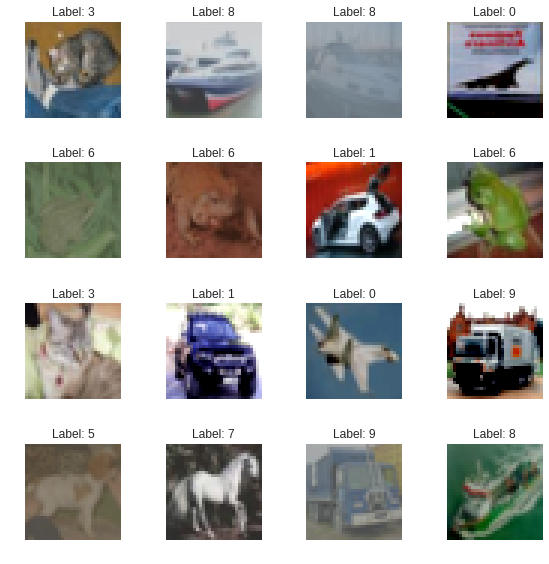

In [6]:
with tf.Session() as sess:
    input_fn = get_input_fn(
        filenames=[os.path.join(data_dir, 'test_batch.bin')],
        batch_size=16,
        num_epochs=1,
        shuffle=False,
        augment=True)

    features, labels = input_fn()
    image_batch, label_batch = sess.run([features['image'], labels['label']])
    print('Images Min:', image_batch.min(), 'Max:', image_batch.max())

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(image_batch[i])
        ax.grid(False)
        ax.axis('off')
        ax.set_title('Label: {}'.format(label_batch[i]))
    plt.tight_layout()

# Model

In [0]:
def batch_norm(inputs, momentum, training):
    return tf.layers.batch_normalization(
        inputs=inputs,
        scale=False,
        momentum=momentum,
        training=training,
        fused=True)

def resnet_block(inputs, filters, strides, training, params):
    kernel_initializer = tf.initializers.variance_scaling(scale=2.0)
    kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=params['l2_scale'])

    inputs = batch_norm(
        inputs=inputs,
        momentum=params['bn_momentum'],
        training=training)
    inputs = tf.nn.relu(inputs)

    hidden = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=3,
        strides=strides,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer,
        padding='same')

    hidden = batch_norm(
        inputs=hidden,
        momentum=params['bn_momentum'],
        training=training)
    hidden = tf.nn.relu(hidden)
    hidden = tf.layers.conv2d(
        inputs=hidden,
        filters=filters,
        kernel_size=3,
        strides=1,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer,
        padding='same')

    inputs_padded = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=1,
        strides=strides,
        use_bias=False,
        padding='same',
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer)
    hidden = hidden + inputs_padded
    
    return hidden

def resnet_layer(inputs, filters, strides, training, params):
    hidden = resnet_block(inputs, filters, strides, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    return hidden

In [0]:
def model_fn(features, labels, mode, params):
    kernel_initializer = tf.initializers.variance_scaling(scale=2.0)
    kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=params['l2_scale'])
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    num_classes = 10

    inputs = features['image'] * 2 - 1

    hidden = tf.layers.conv2d(
        inputs=inputs,
        filters=16,
        kernel_size=3,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer,
        padding='same')

    hidden = resnet_layer(hidden, filters=16, strides=2, training=training, params=params)
    #hidden = resnet_layer(hidden, filters=16, strides=1, training=training, params=params)
    #hidden = resnet_layer(hidden, filters=16, strides=1, training=training, params=params)
    #hidden = resnet_layer(hidden, filters=32, strides=1, training=training, params=params)
    #hidden = resnet_layer(hidden, filters=64, strides=1, training=training, params=params)

    hidden = batch_norm(
        inputs=hidden,
        momentum=params['bn_momentum'],
        training=training)
    hidden = tf.nn.relu(hidden)

    hidden = tf.reduce_mean(hidden, axis=[1, 2])

    logits = tf.layers.dense(
        inputs=hidden,
        units=num_classes,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer)

    outputs = tf.nn.softmax(logits)
    prediction = tf.argmax(outputs, axis=-1)
    
    predictions = {
        'prediction': prediction
    }

    loss = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels=labels['label'],
            logits=logits)
        loss = tf.losses.get_total_loss()
        
    train_op = None
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.piecewise_constant(
            boundaries=params['lr_boundaries'],
            values=params['lr_values'],
            x=global_step)

        optimizer = tf.train.MomentumOptimizer(
            learning_rate=learning_rate,
            momentum=params['momentum'])
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            train_op = optimizer.minimize(
                global_step=global_step,
                loss=loss)

    eval_metric_ops = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(
                predictions=predictions['prediction'],
                labels=labels['label'])
        }

    estimator_spec = tf.estimator.EstimatorSpec(
        loss=loss,
        mode=mode,
        train_op=train_op,
        predictions=predictions,
        eval_metric_ops=eval_metric_ops)
    return estimator_spec

# Training

In [29]:
max_steps_train = 10000
batch_size = 256
model_dir = os.path.join('jobs/', str(int(time.time())))
print('Model Directory:', model_dir)

params = {
    'l2_scale': 1e-4,
    'lr_values': [1e-1, 1e-2, 1e-3],
    'lr_boundaries': [max_steps_train // 3, max_steps_train // 3 * 2],
    'bn_momentum': 0.99,
    'momentum': 0.9,
}
print('Hyperparameters:', params)

config = tf.estimator.RunConfig(
    save_checkpoints_steps=1000,
    save_checkpoints_secs=None,
    save_summary_steps=100)

tf.logging.set_verbosity(tf.logging.INFO)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    model_dir=model_dir,
    config=config,
    params=params)

filenames_train = [
    os.path.join(data_dir, 'data_batch_{}.bin'.format(i))
    for i in xrange(1, 6)]
filenames_eval = [os.path.join(data_dir, 'test_batch.bin')]

input_fn_train = get_input_fn(
    filenames=filenames_train,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=True,
    augment=True)
input_fn_eval = get_input_fn(
    filenames=filenames_eval,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False,
    augment=False)

train_spec = tf.estimator.TrainSpec(
    input_fn=input_fn_train,
    max_steps=max_steps_train)
eval_spec = tf.estimator.EvalSpec(
    input_fn=input_fn_eval,
    start_delay_secs=0,
    throttle_secs=60 * 5)

tf.estimator.train_and_evaluate(
    train_spec=train_spec,
    eval_spec=eval_spec,
    estimator=estimator)

Model Directory: jobs/1531952916
Hyperparameters: {'lr_boundaries': [3333, 6666], 'momentum': 0.9, 'bn_momentum': 0.99, 'l2_scale': 0.0001, 'lr_values': [0.1, 0.01, 0.001]}
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1720fa0d0>, '_evaluation_master': '', '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'jobs/1531952916', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 300 secs (eval_spec.throttle_sec

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:29:29
INFO:tensorflow:Saving dict for global step 392: accuracy = 0.3945, global_step = 392, loss = 1.7490101
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 392: jobs/1531952916/model.ckpt-392
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-392
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 392 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 1.4242495, step = 392
INFO:tensorflow:global_step/sec: 11.5145
INFO:tensorflow:loss = 1.4302735, step = 492 (8.687 sec)
INFO:tensorflow:Sav

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-784
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 784 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 1.0909792, step = 784
INFO:tensorflow:global_step/sec: 11.454
INFO:tensorflow:loss = 1.1268712, step = 884 (8.738 sec)
INFO:tensorflow:Saving checkpoints for 980 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 1.4879646.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:30:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-980
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluat

INFO:tensorflow:loss = 1.0860685, step = 1176
INFO:tensorflow:global_step/sec: 11.3388
INFO:tensorflow:loss = 1.0931851, step = 1276 (8.824 sec)
INFO:tensorflow:Saving checkpoints for 1372 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 1.064633.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:31:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-1372
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:31:38
INFO:tensorflow:Saving dict for global step 1372: accuracy = 0.6232, global_step = 1372, loss = 1.096455
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1372: jobs/1531952916/model.ckpt

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-1764
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:32:30
INFO:tensorflow:Saving dict for global step 1764: accuracy = 0.6119, global_step = 1764, loss = 1.1428801
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1764: jobs/1531952916/model.ckpt-1764
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-1764
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1764 into jobs/1531952916/model.ckpt.
INFO:t

INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:33:23
INFO:tensorflow:Saving dict for global step 2156: accuracy = 0.6415, global_step = 2156, loss = 1.1274569
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2156: jobs/1531952916/model.ckpt-2156
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-2156
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2156 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.94911015, step = 2156
INFO:tensorflow:global_step/sec: 11.209
INFO:tensorflow:loss = 0.8609535, step = 2256 (8.932 sec)
INFO:tensorflow:Saving checkpoints for 2352 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.87007284.
INFO:tensorflow:Calling model_fn.
INF

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-2548
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2548 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.8279925, step = 2548
INFO:tensorflow:global_step/sec: 11.1867
INFO:tensorflow:loss = 0.93484825, step = 2648 (8.941 sec)
INFO:tensorflow:Saving checkpoints for 2744 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7830824.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:34:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-2744
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 11.1435
INFO:tensorflow:loss = 0.8387805, step = 3040 (8.983 sec)
INFO:tensorflow:Saving checkpoints for 3136 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.78830624.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:35:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-3136
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:35:35
INFO:tensorflow:Saving dict for global step 3136: accuracy = 0.523, global_step = 3136, loss = 1.601244
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3136: jobs/1531952916/model.ckpt-3136
INFO:tensorflow:Calling model_fn.
INFO:

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-3528
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:36:28
INFO:tensorflow:Saving dict for global step 3528: accuracy = 0.7604, global_step = 3528, loss = 0.76718336
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3528: jobs/1531952916/model.ckpt-3528
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-3528
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3528 into jobs/1531952916/model.ckpt.
INFO:

INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:37:21
INFO:tensorflow:Saving dict for global step 3920: accuracy = 0.76, global_step = 3920, loss = 0.75979644
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3920: jobs/1531952916/model.ckpt-3920
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-3920
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3920 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.6686795, step = 3920
INFO:tensorflow:global_step/sec: 11.2101
INFO:tensorflow:loss = 0.6853267, step = 4020 (8.922 sec)
INFO:tensorflow:Saving checkpoints for 4116 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 1.000063.
INFO:tensorflow:Calling model_fn.
INFO:t

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-4312
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 4312 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.7040085, step = 4312
INFO:tensorflow:global_step/sec: 11.3348
INFO:tensorflow:loss = 0.7605391, step = 4412 (8.828 sec)
INFO:tensorflow:Saving checkpoints for 4508 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7755406.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:38:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-4508
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:E

INFO:tensorflow:global_step/sec: 11.377
INFO:tensorflow:loss = 0.67542446, step = 4804 (8.800 sec)
INFO:tensorflow:Saving checkpoints for 4900 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.66576976.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:39:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-4900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:39:32
INFO:tensorflow:Saving dict for global step 4900: accuracy = 0.7682, global_step = 4900, loss = 0.74170864
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4900: jobs/1531952916/model.ckpt-4900
INFO:tensorflow:Calling model_fn.
IN

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-5292
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:40:25
INFO:tensorflow:Saving dict for global step 5292: accuracy = 0.7619, global_step = 5292, loss = 0.7607501
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5292: jobs/1531952916/model.ckpt-5292
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-5292
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5292 into jobs/1531952916/model.ckpt.
INFO:t

INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:41:17
INFO:tensorflow:Saving dict for global step 5684: accuracy = 0.7613, global_step = 5684, loss = 0.7622845
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5684: jobs/1531952916/model.ckpt-5684
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-5684
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5684 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.6320765, step = 5684
INFO:tensorflow:global_step/sec: 11.2459
INFO:tensorflow:loss = 0.6329513, step = 5784 (8.900 sec)
INFO:tensorflow:Saving checkpoints for 5880 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.6165414.
INFO:tensorflow:Calling model_fn.
INFO

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-6076
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6076 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.71315354, step = 6076
INFO:tensorflow:global_step/sec: 11.2546
INFO:tensorflow:loss = 0.75931525, step = 6176 (8.896 sec)
INFO:tensorflow:Saving checkpoints for 6272 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.8739346.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:42:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-6272
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow

INFO:tensorflow:global_step/sec: 11.3089
INFO:tensorflow:loss = 0.73263127, step = 6568 (8.852 sec)
INFO:tensorflow:Saving checkpoints for 6664 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.9045149.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:43:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-6664
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:43:29
INFO:tensorflow:Saving dict for global step 6664: accuracy = 0.7686, global_step = 6664, loss = 0.73358506
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6664: jobs/1531952916/model.ckpt-6664
INFO:tensorflow:Calling model_fn.
IN

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-7056
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:44:21
INFO:tensorflow:Saving dict for global step 7056: accuracy = 0.7744, global_step = 7056, loss = 0.71964824
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7056: jobs/1531952916/model.ckpt-7056
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-7056
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7056 into jobs/1531952916/model.ckpt.
INFO:

INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:45:13
INFO:tensorflow:Saving dict for global step 7448: accuracy = 0.7757, global_step = 7448, loss = 0.7188652
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7448: jobs/1531952916/model.ckpt-7448
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-7448
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7448 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.60641044, step = 7448
INFO:tensorflow:global_step/sec: 11.3303
INFO:tensorflow:loss = 0.6246575, step = 7548 (8.835 sec)
INFO:tensorflow:Saving checkpoints for 7644 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.73035544.
INFO:tensorflow:Calling model_fn.
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-7840
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7840 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.7322754, step = 7840
INFO:tensorflow:global_step/sec: 11.5076
INFO:tensorflow:loss = 0.5744172, step = 7940 (8.698 sec)
INFO:tensorflow:Saving checkpoints for 8036 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.6006839.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:46:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-8036
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:E

INFO:tensorflow:global_step/sec: 11.5032
INFO:tensorflow:loss = 0.66978884, step = 8332 (8.696 sec)
INFO:tensorflow:Saving checkpoints for 8428 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.85994166.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:47:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-8428
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:47:23
INFO:tensorflow:Saving dict for global step 8428: accuracy = 0.775, global_step = 8428, loss = 0.71872616
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8428: jobs/1531952916/model.ckpt-8428
INFO:tensorflow:Calling model_fn.
IN

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-8820
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:48:16
INFO:tensorflow:Saving dict for global step 8820: accuracy = 0.7753, global_step = 8820, loss = 0.71855104
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8820: jobs/1531952916/model.ckpt-8820
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-8820
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8820 into jobs/1531952916/model.ckpt.
INFO:

INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:49:07
INFO:tensorflow:Saving dict for global step 9212: accuracy = 0.777, global_step = 9212, loss = 0.7170502
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9212: jobs/1531952916/model.ckpt-9212
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-9212
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9212 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.74107033, step = 9212
INFO:tensorflow:global_step/sec: 11.4328
INFO:tensorflow:loss = 0.6439933, step = 9312 (8.758 sec)
INFO:tensorflow:Saving checkpoints for 9408 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7595264.
INFO:tensorflow:Calling model_fn.
INFO

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-9604
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9604 into jobs/1531952916/model.ckpt.
INFO:tensorflow:loss = 0.6907961, step = 9604
INFO:tensorflow:global_step/sec: 11.3953
INFO:tensorflow:loss = 0.54340196, step = 9704 (8.785 sec)
INFO:tensorflow:Saving checkpoints for 9800 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7785628.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:50:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-9800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:

INFO:tensorflow:Saving checkpoints for 10000 into jobs/1531952916/model.ckpt.
INFO:tensorflow:Loss for final step: 0.63786316.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-18-22:51:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from jobs/1531952916/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Finished evaluation at 2018-07-18-22:51:04
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.7758, global_step = 10000, loss = 0.71549886
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: jobs/1531952916/model.ckpt-10000


({'accuracy': 0.7758, 'global_step': 10000, 'loss': 0.71549886}, [])

# Download

You can download the model directory for inspection via TensorBoard.

In [0]:
model_tarball = model_dir + '.tar.gz'
with tarfile.open(model_tarball, "w:gz") as tar:
    tar.add(model_dir, arcname=os.path.basename(model_dir))
files.download(model_tarball)

jobs/1522767533.tar.gz


# Summary Overview: 

  The observations below are only my observation based on the original given code. I modified some paramaters and the following is my observation of these modifications. I implimented a different Resnet V2 and also a simple convolution net and my code is provided in two seperate ipython files. 

  First I tried data augmentation to the images, based on the initial setup that was done in code like random flipping the images, britness adjustements ...etc. But it did not change the accuracy, which I suspected at least an extra boast of at least 3% but that was not the case. I suspected maybe the model needs extra trading so I increased the number of steps and epoches.  

  I tried increasing the epochs and the number of steps which is expected to increase accuracy. But there was not a significant change in the result. So I started to think about what could be wrong in the architecture. 

  Having a look at the code, I believe what is intended to achieve from this code is to develop a ResNet V2 like the one in [1] , however, I can see that the downsampling that was implemented in the code (strides) and the skip connection is not properly done like explained in the literatire. Now this could be a problem or it may nesseraly be a type of an architecture that I am not familiar with. 

  Comparing the implementation of the paper and the given implementaiton in this code I do not see an obvious fundamental mistake of how a resnet network should look like. But a resnet with a deep architecture like this one should give a result more than 90% accuracy on this dataset.

  I wondered to see if there could be a hidden problem with the way the skip connection is done or the downsampling of the network. At first I tried a simple convolution architecture apporach with only two layers of conv net with reul and max polling (without skip connection or residual inputs) and the result was 78% accuracy. The implementation is shown in the upcoming sections. Also, it is worth to mention that I wanted to see if I add a mean subtraction step to the data after standardizing it to the highest pixel value and it turns out that the resule was 79% accurate. Even though the difference is not that sigificant but it is worth to mention that the convergence was much faster. 
 
  It is expected that a much more deep architecture gives a higher accuracy result, but also a deep archictecture comes with problems such as exploding and vanishing gradients. The residual architecture should address this problem by doing the skip connection trick, however, it is also very sensitive and tricky to implement. Since it is expected that the more the epoches, steps and the deeper the resnet layers the more the accuracy but the implementation provided does not show this. This maked me a little scheptical about how the skip connections are connected between stacks and residual blocks also how the downsampling (strides = 2) is done. For this reason I tried to to reduce the number of residual layers to only one layer and see if the results improve. The moment I commented the lines (removing the last 4 resnet layers in the code) which means it will only run one layer the accuracy has jumped from 57% to 78% at 1000 steps. This confirms it that the residual blocks are not rerouting the residual inputs properly. From my previous experience with residual networks this can be very hard to trace manually in the code so it will be easier to reimplement the code again based on the paper [1] I mentioned above to try something else and they showed some good results so I will try to replicate that. The implementation of this technique is in the following sections. 







# Simple Convolution Architecture

The following is an implementation of a simple conv net with max pooling and dropouts to reduce over fitting. There are  2 layers of each has 2 convolution filters followed by a non-linear activation relu and a maxpooling layer. The model is then flatten to fit in a dense output layer of 10 units. 

Things I tried not in the code: 

- I tried adding a dense layer of 128 after flattening the model and before the output layer. I did this to see if it can improve the results by capturing intra correlations between the layers. This ended up adding extra model complexity as it dramatically increased the number of optimization params and it didnt improve the model accuracy. 

In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import regularizers
from keras import backend as K
from keras.models import Model, Sequential
from keras.datasets import cifar10
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


## Data and Variables 

In [9]:
# retrain model or use saved model
retrain_conv_net = False
# Training parameters
batch_size = 128
epochs = 200
num_classes = 10
# mean subtraction (it improves the accuracy)
mean_subtraction = True
# directory to save models 
save_dir = os.path.join(os.getcwd(), 'saved_models/')
model_name_conv = 'conv_net.h5'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# The data is already split between train and test sets. 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') # convert to float
x_test = x_test.astype('float32') # convert to float
x_train /= 255 # Standarize to the maximum pixel value
x_test /= 255 # Standarize to the maximum pixel value
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
if mean_subtraction:
    train_mean = np.mean(x_train, axis=0)
    x_train = x_train - train_mean
    x_test  = x_test - train_mean 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Model and Training

In [53]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_389 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_375 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_390 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_376 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_391 (Conv2D)          (None, 15, 15, 64)        18496     
__________

In [59]:
if retrain_conv_net:  
    histry = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=True)
    model = histry.model
    model.save_weights(save_dir+model_name_conv)
else:
    model.load_weights(save_dir+model_name_conv)
    print ('Model loaded')

Model loaded


In [60]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 236us/step
Test loss: 0.5917723460197448
Test accuracy: 0.8028


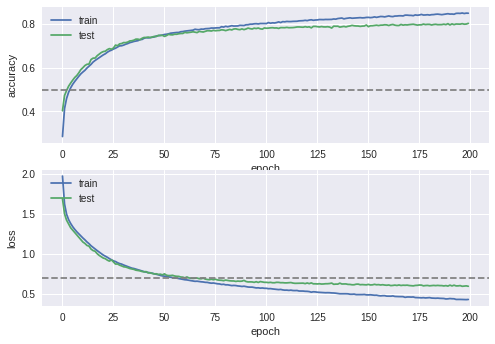

In [56]:
# summarize history for accuracy
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(histry.history['acc'])
plt.plot(histry.history['val_acc'])
plt.axhline(y=0.5, color='grey', linestyle='--')
#plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(histry.history['loss'])
plt.plot(histry.history['val_loss'])
plt.axhline(y=0.693, color='grey', linestyle='--')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('learning_curve_CNN.png', bbox_inches='tight')

## Observation and Discussion 

Surprzingly a simple architecture without residual learning can do a reasnably good job. I intentoinaly trained it on alot of epoches to observe when the model stars to overfit. As you can see the training and the testing error gap starts to widen after 100 epoches thats why the model starts to overfit after 100 epoches which can give about 78% accuracy (without mean subtraction) and 79% after 75 epoches with mean subtraction. A proper resnet architecture should surpase these results. However, it is expected to take so much time to train. Overall, it makes sense that mean subtraction improves the convergence speed as normalization of the data may lead to subtract any comman background noise in the data which may makes it easier to learn edges.  

Another thing worth to mention is that I tried to add a dense layer after flattening the model at the final step to observe if it can capture correlations from the output of the convolution net. But this did not improve the accuracy of the model and added extra computational complexity without any impromevemnts so I decided to remove it. 

# Configurable Resnet V2 implementation 

The following is an implementation of the paper [1] which is a resnetV2. The model consists of 3 stages, each stage consists of an equal number of blocks and each block contrains either 3 or 4 bottel neck. A bottel neck can either be a layer of batchnorm followed by a relu then a convolution layer, or it can be just a convolution layer on its own. The bottle neck is configrued to be only a convolution net when it is forming a new stage. At the begining of each stage the stride is set to be 2 to perform downsampling by 2 and the filter size is increased as well, that way the deeper convolution layers focuses more on the abstract structures of the images. 

The following code is configurable so that it can automatically builds deeper or shollower Resnet model with just adjusting the variable depth. Please note that depth should be multiples of this function f(n) = 9n+2 so it can be 20, 29, 56 or 110. 

The depth in the following code is set at 20, and it uses the same data preprocessing that was set in the last section. 

## Variables 

In [0]:
# retrain model or use saved model
retrain_resnet = False
# Depth of resent V2 model 
depth = 20 #20,56,110,... 1001
#save model_after_train 
model_name_resnet = 'resnetv2_trained.h5'
# Data augmentation 
data_augmentation = True
# Training parameters
batch_size = 256
epochs = 200

## Model:

In [7]:
datagenerator = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)
def learning_rate_adjuster(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

def bottleneck(inputs, 
                no_filters=16,
                kernel_size=3,
                strides=1,
                activation='relu',
                batch_normalization=True):
    x = inputs
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x)
    x = Conv2D(no_filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same',
              kernel_initializer='he_normal',
              kernel_regularizer=l2(1e-4))(x)
    return x

def builder_resnetv2(input_shape, depth, num_classes=10):
    """ 
    This method build a resent v2 architecture based on the desired depth. 
    it builds stacks of bottleneck layers of Batch normalizer, relu then a convolution layer.  
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 20, 29, 56 or 110 in [b])')
    no_filters = 16
    no_blocks = int((depth - 2) / 9)
    inputs = Input(shape=input_shape)
    # Convolution layer with batch norm and relu on input before going deep in path
    x = Conv2D(no_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # build the residual blocks
    for stage in range(3):
        for block in range(no_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                no_filters_next = no_filters * 4
                if block == 0: 
                    activation = None
                    batch_normalization = False
            else:
                no_filters_next = no_filters * 2
                if block == 0:  # first layer but not first stage
                    strides = 2    # downsample by two by skipping 1

            # bottleneck residual block
            b = bottleneck(inputs=x,
                             no_filters=no_filters,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization)
            b = bottleneck(inputs=b,
                             no_filters=no_filters)
            b = bottleneck(inputs=b,
                             no_filters=no_filters_next,
                             kernel_size=1)
            if block == 0:
                # projects the residual skip connection to match the new dimensions
                x = bottleneck(inputs=x,
                                no_filters=no_filters_next,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            # additions should now be executed without mis-dimension errors
            x = keras.layers.add([x, b])
        # change the current filter dimensions with the new one
        no_filters = no_filters_next 

    # Finally the last stage which is Batch norm, relu followed by a polling layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    m = Flatten()(x) # convert to 1D 
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(m)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = builder_resnetv2(x_train.shape[1:], depth)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate_adjuster(0)),metrics=['accuracy'])
save_dir = os.path.join(os.getcwd(), 'saved_models')
m_name = 'resnetv2_depth_%d_model.{epoch:03d}.h5' % depth
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, m_name)
# callbacks for best saved models and for learning rates
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1,save_best_only=True)
lr_scheduler = LearningRateScheduler(learning_rate_adjuster)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_6 (

In [63]:
# Run training, with or without data augmentation.
if retrain_resnet: 
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  callbacks=callbacks)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagenerator.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history = model.fit_generator(datagenerator.flow(x_train, y_train, batch_size=batch_size),
                            validation_data=(x_test, y_test),
                            epochs=epochs, verbose=1, workers=4,
                            callbacks=callbacks)
        model = history.model
        model.save_weights(save_dir+model_name_resnet)
else:
    model.load_weights(save_dir+model_name_resnet)
    print ('Model weights loaded')

Using real-time data augmentation.
Epoch 1/200
196/196 [==============================] - 83s 422ms/step - loss: 1.8390 - acc: 0.4397 - val_loss: 2.0090 - val_acc: 0.4158

Epoch 00001: val_acc improved from -inf to 0.41580, saving model to /content/saved_models/resnetv2_depth_20_model.001.h5
Epoch 2/200
193/196 [============================>.] - ETA: 0s - loss: 1.4380 - acc: 0.5848

196/196 [==============================] - 58s 295ms/step - loss: 1.4364 - acc: 0.5853 - val_loss: 1.3824 - val_acc: 0.6041

Epoch 00002: val_acc improved from 0.41580 to 0.60410, saving model to /content/saved_models/resnetv2_depth_20_model.002.h5
Epoch 3/200
196/196 [==============================] - 58s 294ms/step - loss: 1.2562 - acc: 0.6471 - val_loss: 1.3799 - val_acc: 0.6084

Epoch 00003: val_acc improved from 0.60410 to 0.60840, saving model to /content/saved_models/resnetv2_depth_20_model.003.h5
Epoch 4/200
 51/196 [======>.......................] - ETA: 39s - loss: 1.1750 - acc: 0.6708

196/196 [==============================] - 58s 294ms/step - loss: 1.1370 - acc: 0.6865 - val_loss: 1.4336 - val_acc: 0.5861

Epoch 00004: val_acc did not improve from 0.60840
Epoch 5/200
196/196 [==============================] - 58s 297ms/step - loss: 1.0428 - acc: 0.7170 - val_loss: 1.1956 - val_acc: 0.6781

Epoch 00005: val_acc improved from 0.60840 to 0.67810, saving model to /content/saved_models/resnetv2_depth_20_model.005.h5
Epoch 6/200
 66/196 [=========>....................] - ETA: 35s - loss: 0.9801 - acc: 0.7384

196/196 [==============================] - 59s 302ms/step - loss: 0.9719 - acc: 0.7405 - val_loss: 1.9609 - val_acc: 0.5517

Epoch 00006: val_acc did not improve from 0.67810
Epoch 7/200
196/196 [==============================] - 58s 295ms/step - loss: 0.9091 - acc: 0.7652 - val_loss: 1.2481 - val_acc: 0.6625

Epoch 00007: val_acc did not improve from 0.67810
Epoch 8/200
 80/196 [===========>..................] - ETA: 31s - loss: 0.8715 - acc: 0.7768

196/196 [==============================] - 58s 294ms/step - loss: 0.8652 - acc: 0.7783 - val_loss: 1.3040 - val_acc: 0.6686

Epoch 00008: val_acc did not improve from 0.67810
Epoch 9/200
196/196 [==============================] - 58s 294ms/step - loss: 0.8303 - acc: 0.7892 - val_loss: 1.2753 - val_acc: 0.6633

Epoch 00009: val_acc did not improve from 0.67810
Epoch 10/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.7883 - acc: 0.8035

196/196 [==============================] - 58s 294ms/step - loss: 0.7943 - acc: 0.8006 - val_loss: 0.9738 - val_acc: 0.7465

Epoch 00010: val_acc improved from 0.67810 to 0.74650, saving model to /content/saved_models/resnetv2_depth_20_model.010.h5
Epoch 11/200
196/196 [==============================] - 58s 294ms/step - loss: 0.7653 - acc: 0.8098 - val_loss: 1.0559 - val_acc: 0.7295

Epoch 00011: val_acc did not improve from 0.74650
Epoch 12/200
 42/196 [=====>........................] - ETA: 42s - loss: 0.7329 - acc: 0.8239

196/196 [==============================] - 58s 294ms/step - loss: 0.7400 - acc: 0.8186 - val_loss: 0.9375 - val_acc: 0.7728

Epoch 00012: val_acc improved from 0.74650 to 0.77280, saving model to /content/saved_models/resnetv2_depth_20_model.012.h5
Epoch 13/200
196/196 [==============================] - 58s 295ms/step - loss: 0.7202 - acc: 0.8222 - val_loss: 0.9287 - val_acc: 0.7614

Epoch 00013: val_acc did not improve from 0.77280
Epoch 14/200
 36/196 [====>.........................] - ETA: 43s - loss: 0.6915 - acc: 0.8363

196/196 [==============================] - 58s 295ms/step - loss: 0.7007 - acc: 0.8289 - val_loss: 0.9574 - val_acc: 0.7494

Epoch 00014: val_acc did not improve from 0.77280
Epoch 15/200
196/196 [==============================] - 58s 295ms/step - loss: 0.6789 - acc: 0.8366 - val_loss: 0.8873 - val_acc: 0.7716

Epoch 00015: val_acc did not improve from 0.77280
Epoch 16/200
 74/196 [==========>...................] - ETA: 33s - loss: 0.6522 - acc: 0.8463

196/196 [==============================] - 58s 294ms/step - loss: 0.6594 - acc: 0.8432 - val_loss: 0.8137 - val_acc: 0.7939

Epoch 00016: val_acc improved from 0.77280 to 0.79390, saving model to /content/saved_models/resnetv2_depth_20_model.016.h5
Epoch 17/200
196/196 [==============================] - 58s 294ms/step - loss: 0.6479 - acc: 0.8451 - val_loss: 0.8441 - val_acc: 0.7869

Epoch 00017: val_acc did not improve from 0.79390
Epoch 18/200
 41/196 [=====>........................] - ETA: 41s - loss: 0.6209 - acc: 0.8546

196/196 [==============================] - 58s 295ms/step - loss: 0.6287 - acc: 0.8528 - val_loss: 0.9477 - val_acc: 0.7536

Epoch 00018: val_acc did not improve from 0.79390
Epoch 19/200
196/196 [==============================] - 58s 295ms/step - loss: 0.6161 - acc: 0.8568 - val_loss: 0.7646 - val_acc: 0.8101

Epoch 00019: val_acc improved from 0.79390 to 0.81010, saving model to /content/saved_models/resnetv2_depth_20_model.019.h5
Epoch 20/200
 63/196 [========>.....................] - ETA: 36s - loss: 0.6089 - acc: 0.8603

196/196 [==============================] - 58s 295ms/step - loss: 0.6021 - acc: 0.8619 - val_loss: 0.8010 - val_acc: 0.7978

Epoch 00020: val_acc did not improve from 0.81010
Epoch 21/200
196/196 [==============================] - 58s 294ms/step - loss: 0.5976 - acc: 0.8607 - val_loss: 0.8651 - val_acc: 0.7875

Epoch 00021: val_acc did not improve from 0.81010
Epoch 22/200
 79/196 [===========>..................] - ETA: 31s - loss: 0.5767 - acc: 0.8679

196/196 [==============================] - 58s 294ms/step - loss: 0.5810 - acc: 0.8668 - val_loss: 0.7585 - val_acc: 0.8140

Epoch 00022: val_acc improved from 0.81010 to 0.81400, saving model to /content/saved_models/resnetv2_depth_20_model.022.h5
Epoch 23/200
196/196 [==============================] - 58s 295ms/step - loss: 0.5773 - acc: 0.8675 - val_loss: 0.7667 - val_acc: 0.8102

Epoch 00023: val_acc did not improve from 0.81400
Epoch 24/200
 42/196 [=====>........................] - ETA: 42s - loss: 0.5395 - acc: 0.8832

196/196 [==============================] - 58s 294ms/step - loss: 0.5626 - acc: 0.8728 - val_loss: 0.8056 - val_acc: 0.7974

Epoch 00024: val_acc did not improve from 0.81400
Epoch 25/200
196/196 [==============================] - 58s 294ms/step - loss: 0.5551 - acc: 0.8735 - val_loss: 0.7300 - val_acc: 0.8151

Epoch 00025: val_acc improved from 0.81400 to 0.81510, saving model to /content/saved_models/resnetv2_depth_20_model.025.h5
Epoch 26/200
 64/196 [========>.....................] - ETA: 36s - loss: 0.5319 - acc: 0.8832

196/196 [==============================] - 58s 295ms/step - loss: 0.5469 - acc: 0.8778 - val_loss: 0.7631 - val_acc: 0.8112

Epoch 00026: val_acc did not improve from 0.81510
Epoch 27/200
196/196 [==============================] - 58s 294ms/step - loss: 0.5380 - acc: 0.8791 - val_loss: 0.7221 - val_acc: 0.8224

Epoch 00027: val_acc improved from 0.81510 to 0.82240, saving model to /content/saved_models/resnetv2_depth_20_model.027.h5
Epoch 28/200
 67/196 [=========>....................] - ETA: 35s - loss: 0.5195 - acc: 0.8850

196/196 [==============================] - 58s 294ms/step - loss: 0.5280 - acc: 0.8830 - val_loss: 0.7499 - val_acc: 0.8156

Epoch 00028: val_acc did not improve from 0.82240
Epoch 29/200
196/196 [==============================] - 58s 295ms/step - loss: 0.5173 - acc: 0.8861 - val_loss: 0.7256 - val_acc: 0.8257

Epoch 00029: val_acc improved from 0.82240 to 0.82570, saving model to /content/saved_models/resnetv2_depth_20_model.029.h5
Epoch 30/200
 67/196 [=========>....................] - ETA: 35s - loss: 0.5086 - acc: 0.8885

196/196 [==============================] - 58s 294ms/step - loss: 0.5128 - acc: 0.8868 - val_loss: 0.7593 - val_acc: 0.8212

Epoch 00030: val_acc did not improve from 0.82570
Epoch 31/200
196/196 [==============================] - 58s 295ms/step - loss: 0.5125 - acc: 0.8872 - val_loss: 0.8462 - val_acc: 0.7982

Epoch 00031: val_acc did not improve from 0.82570
Epoch 32/200
 80/196 [===========>..................] - ETA: 31s - loss: 0.4966 - acc: 0.8918

196/196 [==============================] - 58s 295ms/step - loss: 0.5010 - acc: 0.8910 - val_loss: 0.6629 - val_acc: 0.8492

Epoch 00032: val_acc improved from 0.82570 to 0.84920, saving model to /content/saved_models/resnetv2_depth_20_model.032.h5
Epoch 33/200
196/196 [==============================] - 58s 294ms/step - loss: 0.4950 - acc: 0.8944 - val_loss: 0.8861 - val_acc: 0.7976

Epoch 00033: val_acc did not improve from 0.84920
Epoch 34/200
 42/196 [=====>........................] - ETA: 41s - loss: 0.4747 - acc: 0.9022

196/196 [==============================] - 58s 295ms/step - loss: 0.4882 - acc: 0.8962 - val_loss: 0.7242 - val_acc: 0.8230

Epoch 00034: val_acc did not improve from 0.84920
Epoch 35/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4796 - acc: 0.8981 - val_loss: 0.8582 - val_acc: 0.7940

Epoch 00035: val_acc did not improve from 0.84920
Epoch 36/200
 75/196 [==========>...................] - ETA: 33s - loss: 0.4671 - acc: 0.9036

196/196 [==============================] - 58s 295ms/step - loss: 0.4775 - acc: 0.8999 - val_loss: 0.8686 - val_acc: 0.7990

Epoch 00036: val_acc did not improve from 0.84920
Epoch 37/200
196/196 [==============================] - 58s 295ms/step - loss: 0.4741 - acc: 0.8990 - val_loss: 0.9677 - val_acc: 0.7812

Epoch 00037: val_acc did not improve from 0.84920
Epoch 38/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.4569 - acc: 0.9043

196/196 [==============================] - 58s 295ms/step - loss: 0.4651 - acc: 0.9017 - val_loss: 0.7297 - val_acc: 0.8271

Epoch 00038: val_acc did not improve from 0.84920
Epoch 39/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4670 - acc: 0.9029 - val_loss: 0.6783 - val_acc: 0.8366

Epoch 00039: val_acc did not improve from 0.84920
Epoch 40/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.4551 - acc: 0.9073

196/196 [==============================] - 58s 295ms/step - loss: 0.4604 - acc: 0.9043 - val_loss: 0.7343 - val_acc: 0.8258

Epoch 00040: val_acc did not improve from 0.84920
Epoch 41/200
196/196 [==============================] - 58s 294ms/step - loss: 0.4551 - acc: 0.9058 - val_loss: 0.8154 - val_acc: 0.8147

Epoch 00041: val_acc did not improve from 0.84920
Epoch 42/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.4354 - acc: 0.9126

196/196 [==============================] - 58s 295ms/step - loss: 0.4467 - acc: 0.9090 - val_loss: 0.8033 - val_acc: 0.8125

Epoch 00042: val_acc did not improve from 0.84920
Epoch 43/200
196/196 [==============================] - 58s 295ms/step - loss: 0.4439 - acc: 0.9091 - val_loss: 0.8855 - val_acc: 0.8006

Epoch 00043: val_acc did not improve from 0.84920
Epoch 44/200
 82/196 [===========>..................] - ETA: 30s - loss: 0.4314 - acc: 0.9130

196/196 [==============================] - 58s 295ms/step - loss: 0.4442 - acc: 0.9091 - val_loss: 0.8817 - val_acc: 0.7932

Epoch 00044: val_acc did not improve from 0.84920
Epoch 45/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4363 - acc: 0.9116 - val_loss: 0.7734 - val_acc: 0.8176

Epoch 00045: val_acc did not improve from 0.84920
Epoch 46/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.4258 - acc: 0.9151

196/196 [==============================] - 58s 297ms/step - loss: 0.4336 - acc: 0.9124 - val_loss: 0.7111 - val_acc: 0.8394

Epoch 00046: val_acc did not improve from 0.84920
Epoch 47/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4265 - acc: 0.9152 - val_loss: 0.9792 - val_acc: 0.7765

Epoch 00047: val_acc did not improve from 0.84920
Epoch 48/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.4286 - acc: 0.9148

196/196 [==============================] - 58s 297ms/step - loss: 0.4332 - acc: 0.9128 - val_loss: 0.6670 - val_acc: 0.8443

Epoch 00048: val_acc did not improve from 0.84920
Epoch 49/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4227 - acc: 0.9167 - val_loss: 0.9016 - val_acc: 0.7972

Epoch 00049: val_acc did not improve from 0.84920
Epoch 50/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.4168 - acc: 0.9195

196/196 [==============================] - 58s 296ms/step - loss: 0.4253 - acc: 0.9162 - val_loss: 0.9221 - val_acc: 0.7929

Epoch 00050: val_acc did not improve from 0.84920
Epoch 51/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4244 - acc: 0.9159 - val_loss: 0.7074 - val_acc: 0.8432

Epoch 00051: val_acc did not improve from 0.84920
Epoch 52/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.4021 - acc: 0.9224

196/196 [==============================] - 58s 296ms/step - loss: 0.4131 - acc: 0.9201 - val_loss: 0.7208 - val_acc: 0.8285

Epoch 00052: val_acc did not improve from 0.84920
Epoch 53/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4102 - acc: 0.9195 - val_loss: 0.7971 - val_acc: 0.8187

Epoch 00053: val_acc did not improve from 0.84920
Epoch 54/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3931 - acc: 0.9265

196/196 [==============================] - 58s 297ms/step - loss: 0.4117 - acc: 0.9190 - val_loss: 0.7986 - val_acc: 0.8247

Epoch 00054: val_acc did not improve from 0.84920
Epoch 55/200
196/196 [==============================] - 58s 297ms/step - loss: 0.4065 - acc: 0.9214 - val_loss: 0.6135 - val_acc: 0.8574

Epoch 00055: val_acc improved from 0.84920 to 0.85740, saving model to /content/saved_models/resnetv2_depth_20_model.055.h5
Epoch 56/200
 70/196 [=========>....................] - ETA: 34s - loss: 0.3969 - acc: 0.9249

196/196 [==============================] - 58s 296ms/step - loss: 0.4046 - acc: 0.9227 - val_loss: 0.7600 - val_acc: 0.8302

Epoch 00056: val_acc did not improve from 0.85740
Epoch 57/200
196/196 [==============================] - 58s 295ms/step - loss: 0.4051 - acc: 0.9220 - val_loss: 0.7145 - val_acc: 0.8400

Epoch 00057: val_acc did not improve from 0.85740
Epoch 58/200
 80/196 [===========>..................] - ETA: 31s - loss: 0.3911 - acc: 0.9276

196/196 [==============================] - 58s 295ms/step - loss: 0.4012 - acc: 0.9238 - val_loss: 0.6662 - val_acc: 0.8548

Epoch 00058: val_acc did not improve from 0.85740
Epoch 59/200
196/196 [==============================] - 58s 296ms/step - loss: 0.4026 - acc: 0.9244 - val_loss: 0.8557 - val_acc: 0.8170

Epoch 00059: val_acc did not improve from 0.85740
Epoch 60/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3839 - acc: 0.9283

196/196 [==============================] - 58s 296ms/step - loss: 0.3922 - acc: 0.9253 - val_loss: 0.7019 - val_acc: 0.8365

Epoch 00060: val_acc did not improve from 0.85740
Epoch 61/200
196/196 [==============================] - 58s 296ms/step - loss: 0.3892 - acc: 0.9276 - val_loss: 0.6809 - val_acc: 0.8493

Epoch 00061: val_acc did not improve from 0.85740
Epoch 62/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3791 - acc: 0.9327

196/196 [==============================] - 58s 296ms/step - loss: 0.3855 - acc: 0.9294 - val_loss: 0.8248 - val_acc: 0.8190

Epoch 00062: val_acc did not improve from 0.85740
Epoch 63/200
196/196 [==============================] - 58s 296ms/step - loss: 0.3886 - acc: 0.9286 - val_loss: 0.6564 - val_acc: 0.8560

Epoch 00063: val_acc did not improve from 0.85740
Epoch 64/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3735 - acc: 0.9323

196/196 [==============================] - 58s 296ms/step - loss: 0.3855 - acc: 0.9282 - val_loss: 0.7058 - val_acc: 0.8349

Epoch 00064: val_acc did not improve from 0.85740
Epoch 65/200
196/196 [==============================] - 58s 297ms/step - loss: 0.3855 - acc: 0.9287 - val_loss: 0.7321 - val_acc: 0.8479

Epoch 00065: val_acc did not improve from 0.85740
Epoch 66/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3635 - acc: 0.9370

196/196 [==============================] - 58s 297ms/step - loss: 0.3803 - acc: 0.9304 - val_loss: 0.8192 - val_acc: 0.8287

Epoch 00066: val_acc did not improve from 0.85740
Epoch 67/200
196/196 [==============================] - 58s 297ms/step - loss: 0.3851 - acc: 0.9292 - val_loss: 0.8965 - val_acc: 0.8065

Epoch 00067: val_acc did not improve from 0.85740
Epoch 68/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3681 - acc: 0.9350

196/196 [==============================] - 58s 296ms/step - loss: 0.3793 - acc: 0.9302 - val_loss: 1.1947 - val_acc: 0.7496

Epoch 00068: val_acc did not improve from 0.85740
Epoch 69/200
196/196 [==============================] - 58s 297ms/step - loss: 0.3784 - acc: 0.9313 - val_loss: 0.6291 - val_acc: 0.8645

Epoch 00069: val_acc improved from 0.85740 to 0.86450, saving model to /content/saved_models/resnetv2_depth_20_model.069.h5
Epoch 70/200
 70/196 [=========>....................] - ETA: 34s - loss: 0.3603 - acc: 0.9375

196/196 [==============================] - 58s 296ms/step - loss: 0.3705 - acc: 0.9341 - val_loss: 0.7013 - val_acc: 0.8382

Epoch 00070: val_acc did not improve from 0.86450
Epoch 71/200
196/196 [==============================] - 58s 297ms/step - loss: 0.3774 - acc: 0.9311 - val_loss: 0.7066 - val_acc: 0.8450

Epoch 00071: val_acc did not improve from 0.86450
Epoch 72/200
 80/196 [===========>..................] - ETA: 31s - loss: 0.3619 - acc: 0.9371

196/196 [==============================] - 58s 297ms/step - loss: 0.3694 - acc: 0.9344 - val_loss: 0.6658 - val_acc: 0.8548

Epoch 00072: val_acc did not improve from 0.86450
Epoch 73/200
196/196 [==============================] - 58s 296ms/step - loss: 0.3724 - acc: 0.9327 - val_loss: 0.6819 - val_acc: 0.8536

Epoch 00073: val_acc did not improve from 0.86450
Epoch 74/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3535 - acc: 0.9402

196/196 [==============================] - 58s 296ms/step - loss: 0.3665 - acc: 0.9353 - val_loss: 0.7260 - val_acc: 0.8409

Epoch 00074: val_acc did not improve from 0.86450
Epoch 75/200
196/196 [==============================] - 58s 297ms/step - loss: 0.3643 - acc: 0.9357 - val_loss: 0.6603 - val_acc: 0.8615

Epoch 00075: val_acc did not improve from 0.86450
Epoch 76/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3520 - acc: 0.9400

196/196 [==============================] - 58s 297ms/step - loss: 0.3616 - acc: 0.9368 - val_loss: 0.7685 - val_acc: 0.8399

Epoch 00076: val_acc did not improve from 0.86450
Epoch 77/200
196/196 [==============================] - 58s 296ms/step - loss: 0.3666 - acc: 0.9353 - val_loss: 0.7511 - val_acc: 0.8395

Epoch 00077: val_acc did not improve from 0.86450
Epoch 78/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3497 - acc: 0.9413

196/196 [==============================] - 58s 296ms/step - loss: 0.3542 - acc: 0.9389 - val_loss: 0.8867 - val_acc: 0.8099

Epoch 00078: val_acc did not improve from 0.86450
Epoch 79/200
196/196 [==============================] - 58s 296ms/step - loss: 0.3627 - acc: 0.9360 - val_loss: 0.7003 - val_acc: 0.8500

Epoch 00079: val_acc did not improve from 0.86450
Epoch 80/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3499 - acc: 0.9414

196/196 [==============================] - 59s 303ms/step - loss: 0.3594 - acc: 0.9382 - val_loss: 0.8244 - val_acc: 0.8180

Epoch 00080: val_acc did not improve from 0.86450
Epoch 81/200
196/196 [==============================] - 58s 297ms/step - loss: 0.3608 - acc: 0.9373 - val_loss: 0.6816 - val_acc: 0.8594

Epoch 00081: val_acc did not improve from 0.86450
Epoch 82/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.3127 - acc: 0.9563

196/196 [==============================] - 58s 297ms/step - loss: 0.2986 - acc: 0.9614 - val_loss: 0.5137 - val_acc: 0.8987

Epoch 00082: val_acc improved from 0.86450 to 0.89870, saving model to /content/saved_models/resnetv2_depth_20_model.082.h5
Epoch 83/200
196/196 [==============================] - 58s 297ms/step - loss: 0.2734 - acc: 0.9698 - val_loss: 0.5127 - val_acc: 0.8962

Epoch 00083: val_acc did not improve from 0.89870
Epoch 84/200
 42/196 [=====>........................] - ETA: 42s - loss: 0.2627 - acc: 0.9757

196/196 [==============================] - 58s 296ms/step - loss: 0.2636 - acc: 0.9741 - val_loss: 0.5091 - val_acc: 0.8998

Epoch 00084: val_acc improved from 0.89870 to 0.89980, saving model to /content/saved_models/resnetv2_depth_20_model.084.h5
Epoch 85/200
196/196 [==============================] - 58s 295ms/step - loss: 0.2564 - acc: 0.9756 - val_loss: 0.5184 - val_acc: 0.8987

Epoch 00085: val_acc did not improve from 0.89980
Epoch 86/200
 36/196 [====>.........................] - ETA: 44s - loss: 0.2497 - acc: 0.9780

196/196 [==============================] - 58s 297ms/step - loss: 0.2500 - acc: 0.9779 - val_loss: 0.5151 - val_acc: 0.9019

Epoch 00086: val_acc improved from 0.89980 to 0.90190, saving model to /content/saved_models/resnetv2_depth_20_model.086.h5
Epoch 87/200
196/196 [==============================] - 58s 297ms/step - loss: 0.2473 - acc: 0.9780 - val_loss: 0.5047 - val_acc: 0.9023

Epoch 00087: val_acc improved from 0.90190 to 0.90230, saving model to /content/saved_models/resnetv2_depth_20_model.087.h5
Epoch 88/200
 30/196 [===>..........................] - ETA: 45s - loss: 0.2422 - acc: 0.9801

196/196 [==============================] - 58s 297ms/step - loss: 0.2421 - acc: 0.9797 - val_loss: 0.5051 - val_acc: 0.9039

Epoch 00088: val_acc improved from 0.90230 to 0.90390, saving model to /content/saved_models/resnetv2_depth_20_model.088.h5
Epoch 89/200
196/196 [==============================] - 58s 296ms/step - loss: 0.2388 - acc: 0.9805 - val_loss: 0.5076 - val_acc: 0.9040

Epoch 00089: val_acc improved from 0.90390 to 0.90400, saving model to /content/saved_models/resnetv2_depth_20_model.089.h5
Epoch 90/200
 29/196 [===>..........................] - ETA: 45s - loss: 0.2347 - acc: 0.9820

196/196 [==============================] - 58s 297ms/step - loss: 0.2371 - acc: 0.9809 - val_loss: 0.5084 - val_acc: 0.9013

Epoch 00090: val_acc did not improve from 0.90400
Epoch 91/200
196/196 [==============================] - 58s 296ms/step - loss: 0.2315 - acc: 0.9822 - val_loss: 0.5071 - val_acc: 0.9053

Epoch 00091: val_acc improved from 0.90400 to 0.90530, saving model to /content/saved_models/resnetv2_depth_20_model.091.h5
Epoch 92/200
 62/196 [========>.....................] - ETA: 37s - loss: 0.2259 - acc: 0.9847

196/196 [==============================] - 58s 297ms/step - loss: 0.2271 - acc: 0.9836 - val_loss: 0.5057 - val_acc: 0.9039

Epoch 00092: val_acc did not improve from 0.90530
Epoch 93/200
196/196 [==============================] - 58s 296ms/step - loss: 0.2251 - acc: 0.9829 - val_loss: 0.5140 - val_acc: 0.9026

Epoch 00093: val_acc did not improve from 0.90530
Epoch 94/200
 79/196 [===========>..................] - ETA: 31s - loss: 0.2213 - acc: 0.9850

196/196 [==============================] - 58s 296ms/step - loss: 0.2217 - acc: 0.9846 - val_loss: 0.5154 - val_acc: 0.9038

Epoch 00094: val_acc did not improve from 0.90530
Epoch 95/200
196/196 [==============================] - 58s 296ms/step - loss: 0.2188 - acc: 0.9852 - val_loss: 0.5152 - val_acc: 0.9019

Epoch 00095: val_acc did not improve from 0.90530
Epoch 96/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.2159 - acc: 0.9855

196/196 [==============================] - 58s 296ms/step - loss: 0.2169 - acc: 0.9848 - val_loss: 0.5199 - val_acc: 0.9025

Epoch 00096: val_acc did not improve from 0.90530
Epoch 97/200
196/196 [==============================] - 58s 296ms/step - loss: 0.2116 - acc: 0.9870 - val_loss: 0.5199 - val_acc: 0.9046

Epoch 00097: val_acc did not improve from 0.90530
Epoch 98/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.2107 - acc: 0.9866

196/196 [==============================] - 58s 297ms/step - loss: 0.2113 - acc: 0.9861 - val_loss: 0.5294 - val_acc: 0.9030

Epoch 00098: val_acc did not improve from 0.90530
Epoch 99/200
196/196 [==============================] - 58s 297ms/step - loss: 0.2115 - acc: 0.9855 - val_loss: 0.5504 - val_acc: 0.9003

Epoch 00099: val_acc did not improve from 0.90530
Epoch 100/200
 82/196 [===========>..................] - ETA: 31s - loss: 0.2056 - acc: 0.9877

196/196 [==============================] - 58s 297ms/step - loss: 0.2079 - acc: 0.9865 - val_loss: 0.5307 - val_acc: 0.9026

Epoch 00100: val_acc did not improve from 0.90530
Epoch 101/200
196/196 [==============================] - 58s 297ms/step - loss: 0.2062 - acc: 0.9866 - val_loss: 0.5255 - val_acc: 0.9028

Epoch 00101: val_acc did not improve from 0.90530
Epoch 102/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.2042 - acc: 0.9862

196/196 [==============================] - 58s 297ms/step - loss: 0.2047 - acc: 0.9866 - val_loss: 0.5241 - val_acc: 0.9010

Epoch 00102: val_acc did not improve from 0.90530
Epoch 103/200
196/196 [==============================] - 58s 297ms/step - loss: 0.2004 - acc: 0.9885 - val_loss: 0.5211 - val_acc: 0.9033

Epoch 00103: val_acc did not improve from 0.90530
Epoch 104/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1980 - acc: 0.9887

196/196 [==============================] - 58s 296ms/step - loss: 0.2003 - acc: 0.9879 - val_loss: 0.5254 - val_acc: 0.9039

Epoch 00104: val_acc did not improve from 0.90530
Epoch 105/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1969 - acc: 0.9885 - val_loss: 0.5150 - val_acc: 0.9036

Epoch 00105: val_acc did not improve from 0.90530
Epoch 106/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1953 - acc: 0.9891

196/196 [==============================] - 58s 297ms/step - loss: 0.1963 - acc: 0.9884 - val_loss: 0.5283 - val_acc: 0.9029

Epoch 00106: val_acc did not improve from 0.90530
Epoch 107/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1940 - acc: 0.9884 - val_loss: 0.5177 - val_acc: 0.9055

Epoch 00107: val_acc improved from 0.90530 to 0.90550, saving model to /content/saved_models/resnetv2_depth_20_model.107.h5
Epoch 108/200
 69/196 [=========>....................] - ETA: 34s - loss: 0.1882 - acc: 0.9906

196/196 [==============================] - 58s 296ms/step - loss: 0.1913 - acc: 0.9895 - val_loss: 0.5306 - val_acc: 0.9006

Epoch 00108: val_acc did not improve from 0.90550
Epoch 109/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1905 - acc: 0.9893 - val_loss: 0.5418 - val_acc: 0.9002

Epoch 00109: val_acc did not improve from 0.90550
Epoch 110/200
 79/196 [===========>..................] - ETA: 32s - loss: 0.1872 - acc: 0.9910

196/196 [==============================] - 58s 296ms/step - loss: 0.1892 - acc: 0.9897 - val_loss: 0.5277 - val_acc: 0.9047

Epoch 00110: val_acc did not improve from 0.90550
Epoch 111/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1863 - acc: 0.9902 - val_loss: 0.5279 - val_acc: 0.9045

Epoch 00111: val_acc did not improve from 0.90550
Epoch 112/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1843 - acc: 0.9901

196/196 [==============================] - 58s 296ms/step - loss: 0.1845 - acc: 0.9901 - val_loss: 0.5402 - val_acc: 0.9006

Epoch 00112: val_acc did not improve from 0.90550
Epoch 113/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1841 - acc: 0.9903 - val_loss: 0.5301 - val_acc: 0.9020

Epoch 00113: val_acc did not improve from 0.90550
Epoch 114/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1815 - acc: 0.9913

196/196 [==============================] - 58s 297ms/step - loss: 0.1813 - acc: 0.9909 - val_loss: 0.5212 - val_acc: 0.9034

Epoch 00114: val_acc did not improve from 0.90550
Epoch 115/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1803 - acc: 0.9907 - val_loss: 0.5188 - val_acc: 0.9061

Epoch 00115: val_acc improved from 0.90550 to 0.90610, saving model to /content/saved_models/resnetv2_depth_20_model.115.h5
Epoch 116/200
 69/196 [=========>....................] - ETA: 35s - loss: 0.1809 - acc: 0.9896

196/196 [==============================] - 58s 297ms/step - loss: 0.1786 - acc: 0.9911 - val_loss: 0.5417 - val_acc: 0.8991

Epoch 00116: val_acc did not improve from 0.90610
Epoch 117/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1776 - acc: 0.9905 - val_loss: 0.5255 - val_acc: 0.9039

Epoch 00117: val_acc did not improve from 0.90610
Epoch 118/200
 79/196 [===========>..................] - ETA: 32s - loss: 0.1741 - acc: 0.9926

196/196 [==============================] - 58s 297ms/step - loss: 0.1764 - acc: 0.9911 - val_loss: 0.5402 - val_acc: 0.9004

Epoch 00118: val_acc did not improve from 0.90610
Epoch 119/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1747 - acc: 0.9911 - val_loss: 0.5286 - val_acc: 0.9024

Epoch 00119: val_acc did not improve from 0.90610
Epoch 120/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1736 - acc: 0.9907

196/196 [==============================] - 58s 298ms/step - loss: 0.1729 - acc: 0.9913 - val_loss: 0.5373 - val_acc: 0.8997

Epoch 00120: val_acc did not improve from 0.90610
Epoch 121/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1714 - acc: 0.9921 - val_loss: 0.5326 - val_acc: 0.9045

Epoch 00121: val_acc did not improve from 0.90610
Epoch 122/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1701 - acc: 0.9922

196/196 [==============================] - 58s 297ms/step - loss: 0.1692 - acc: 0.9928 - val_loss: 0.5161 - val_acc: 0.9071

Epoch 00122: val_acc improved from 0.90610 to 0.90710, saving model to /content/saved_models/resnetv2_depth_20_model.122.h5
Epoch 123/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1673 - acc: 0.9931 - val_loss: 0.5162 - val_acc: 0.9084

Epoch 00123: val_acc improved from 0.90710 to 0.90840, saving model to /content/saved_models/resnetv2_depth_20_model.123.h5
Epoch 124/200
 36/196 [====>.........................] - ETA: 44s - loss: 0.1689 - acc: 0.9920

196/196 [==============================] - 58s 297ms/step - loss: 0.1656 - acc: 0.9941 - val_loss: 0.5163 - val_acc: 0.9087

Epoch 00124: val_acc improved from 0.90840 to 0.90870, saving model to /content/saved_models/resnetv2_depth_20_model.124.h5
Epoch 125/200
196/196 [==============================] - 58s 298ms/step - loss: 0.1666 - acc: 0.9932 - val_loss: 0.5158 - val_acc: 0.9081

Epoch 00125: val_acc did not improve from 0.90870
Epoch 126/200
 35/196 [====>.........................] - ETA: 43s - loss: 0.1666 - acc: 0.9924

196/196 [==============================] - 58s 296ms/step - loss: 0.1652 - acc: 0.9940 - val_loss: 0.5141 - val_acc: 0.9083

Epoch 00126: val_acc did not improve from 0.90870
Epoch 127/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1649 - acc: 0.9940 - val_loss: 0.5133 - val_acc: 0.9082

Epoch 00127: val_acc did not improve from 0.90870
Epoch 128/200
 73/196 [==========>...................] - ETA: 33s - loss: 0.1647 - acc: 0.9936

196/196 [==============================] - 58s 297ms/step - loss: 0.1641 - acc: 0.9943 - val_loss: 0.5155 - val_acc: 0.9065

Epoch 00128: val_acc did not improve from 0.90870
Epoch 129/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1639 - acc: 0.9949 - val_loss: 0.5156 - val_acc: 0.9071

Epoch 00129: val_acc did not improve from 0.90870
Epoch 130/200
 80/196 [===========>..................] - ETA: 31s - loss: 0.1651 - acc: 0.9939

196/196 [==============================] - 58s 296ms/step - loss: 0.1639 - acc: 0.9943 - val_loss: 0.5149 - val_acc: 0.9078

Epoch 00130: val_acc did not improve from 0.90870
Epoch 131/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1635 - acc: 0.9945 - val_loss: 0.5164 - val_acc: 0.9078

Epoch 00131: val_acc did not improve from 0.90870
Epoch 132/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1629 - acc: 0.9945

196/196 [==============================] - 58s 296ms/step - loss: 0.1633 - acc: 0.9942 - val_loss: 0.5147 - val_acc: 0.9083

Epoch 00132: val_acc did not improve from 0.90870
Epoch 133/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1633 - acc: 0.9946 - val_loss: 0.5127 - val_acc: 0.9073

Epoch 00133: val_acc did not improve from 0.90870
Epoch 134/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1631 - acc: 0.9939

196/196 [==============================] - 58s 297ms/step - loss: 0.1634 - acc: 0.9942 - val_loss: 0.5133 - val_acc: 0.9081

Epoch 00134: val_acc did not improve from 0.90870
Epoch 135/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1620 - acc: 0.9949 - val_loss: 0.5119 - val_acc: 0.9085

Epoch 00135: val_acc did not improve from 0.90870
Epoch 136/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1612 - acc: 0.9951

196/196 [==============================] - 58s 297ms/step - loss: 0.1619 - acc: 0.9949 - val_loss: 0.5169 - val_acc: 0.9076

Epoch 00136: val_acc did not improve from 0.90870
Epoch 137/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1635 - acc: 0.9942 - val_loss: 0.5143 - val_acc: 0.9075

Epoch 00137: val_acc did not improve from 0.90870
Epoch 138/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1623 - acc: 0.9945

196/196 [==============================] - 58s 297ms/step - loss: 0.1628 - acc: 0.9942 - val_loss: 0.5160 - val_acc: 0.9087

Epoch 00138: val_acc did not improve from 0.90870
Epoch 139/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1616 - acc: 0.9947 - val_loss: 0.5129 - val_acc: 0.9073

Epoch 00139: val_acc did not improve from 0.90870
Epoch 140/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1621 - acc: 0.9946

196/196 [==============================] - 58s 296ms/step - loss: 0.1620 - acc: 0.9947 - val_loss: 0.5154 - val_acc: 0.9086

Epoch 00140: val_acc did not improve from 0.90870
Epoch 141/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1611 - acc: 0.9953 - val_loss: 0.5146 - val_acc: 0.9087

Epoch 00141: val_acc did not improve from 0.90870
Epoch 142/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1606 - acc: 0.9952

196/196 [==============================] - 58s 295ms/step - loss: 0.1607 - acc: 0.9955 - val_loss: 0.5167 - val_acc: 0.9079

Epoch 00142: val_acc did not improve from 0.90870
Epoch 143/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1612 - acc: 0.9947 - val_loss: 0.5145 - val_acc: 0.9081

Epoch 00143: val_acc did not improve from 0.90870
Epoch 144/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1599 - acc: 0.9954

196/196 [==============================] - 58s 296ms/step - loss: 0.1603 - acc: 0.9952 - val_loss: 0.5186 - val_acc: 0.9082

Epoch 00144: val_acc did not improve from 0.90870
Epoch 145/200
196/196 [==============================] - 58s 297ms/step - loss: 0.1596 - acc: 0.9954 - val_loss: 0.5152 - val_acc: 0.9081

Epoch 00145: val_acc did not improve from 0.90870
Epoch 146/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1602 - acc: 0.9951

196/196 [==============================] - 58s 296ms/step - loss: 0.1607 - acc: 0.9948 - val_loss: 0.5193 - val_acc: 0.9083

Epoch 00146: val_acc did not improve from 0.90870
Epoch 147/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1598 - acc: 0.9951 - val_loss: 0.5153 - val_acc: 0.9076

Epoch 00147: val_acc did not improve from 0.90870
Epoch 148/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1592 - acc: 0.9954

196/196 [==============================] - 58s 296ms/step - loss: 0.1595 - acc: 0.9952 - val_loss: 0.5153 - val_acc: 0.9083

Epoch 00148: val_acc did not improve from 0.90870
Epoch 149/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1596 - acc: 0.9953 - val_loss: 0.5159 - val_acc: 0.9094

Epoch 00149: val_acc improved from 0.90870 to 0.90940, saving model to /content/saved_models/resnetv2_depth_20_model.149.h5
Epoch 150/200
 69/196 [=========>....................] - ETA: 34s - loss: 0.1588 - acc: 0.9958

196/196 [==============================] - 58s 296ms/step - loss: 0.1593 - acc: 0.9954 - val_loss: 0.5157 - val_acc: 0.9097

Epoch 00150: val_acc improved from 0.90940 to 0.90970, saving model to /content/saved_models/resnetv2_depth_20_model.150.h5
Epoch 151/200
196/196 [==============================] - 58s 296ms/step - loss: 0.1596 - acc: 0.9950 - val_loss: 0.5178 - val_acc: 0.9091

Epoch 00151: val_acc did not improve from 0.90970
Epoch 152/200
 40/196 [=====>........................] - ETA: 42s - loss: 0.1584 - acc: 0.9962

196/196 [==============================] - 58s 296ms/step - loss: 0.1596 - acc: 0.9951 - val_loss: 0.5160 - val_acc: 0.9084

Epoch 00152: val_acc did not improve from 0.90970
Epoch 153/200
196/196 [==============================] - 58s 295ms/step - loss: 0.1594 - acc: 0.9952 - val_loss: 0.5131 - val_acc: 0.9095

Epoch 00153: val_acc did not improve from 0.90970
Epoch 154/200
 74/196 [==========>...................] - ETA: 33s - loss: 0.1590 - acc: 0.9952

196/196 [==============================] - 58s 295ms/step - loss: 0.1587 - acc: 0.9953 - val_loss: 0.5189 - val_acc: 0.9073

Epoch 00154: val_acc did not improve from 0.90970
Epoch 155/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1587 - acc: 0.9954 - val_loss: 0.5192 - val_acc: 0.9084

Epoch 00155: val_acc did not improve from 0.90970
Epoch 156/200
 80/196 [===========>..................] - ETA: 31s - loss: 0.1603 - acc: 0.9946

196/196 [==============================] - 58s 294ms/step - loss: 0.1594 - acc: 0.9949 - val_loss: 0.5195 - val_acc: 0.9081

Epoch 00156: val_acc did not improve from 0.90970
Epoch 157/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1580 - acc: 0.9955 - val_loss: 0.5170 - val_acc: 0.9087

Epoch 00157: val_acc did not improve from 0.90970
Epoch 158/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1583 - acc: 0.9955

196/196 [==============================] - 58s 293ms/step - loss: 0.1584 - acc: 0.9951 - val_loss: 0.5183 - val_acc: 0.9083

Epoch 00158: val_acc did not improve from 0.90970
Epoch 159/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1567 - acc: 0.9961 - val_loss: 0.5211 - val_acc: 0.9084

Epoch 00159: val_acc did not improve from 0.90970
Epoch 160/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1575 - acc: 0.9952

196/196 [==============================] - 58s 294ms/step - loss: 0.1577 - acc: 0.9953 - val_loss: 0.5216 - val_acc: 0.9084

Epoch 00160: val_acc did not improve from 0.90970
Epoch 161/200
196/196 [==============================] - 57s 293ms/step - loss: 0.1576 - acc: 0.9952 - val_loss: 0.5198 - val_acc: 0.9087

Epoch 00161: val_acc did not improve from 0.90970
Epoch 162/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1566 - acc: 0.9951

196/196 [==============================] - 58s 294ms/step - loss: 0.1567 - acc: 0.9954 - val_loss: 0.5197 - val_acc: 0.9089

Epoch 00162: val_acc did not improve from 0.90970
Epoch 163/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1570 - acc: 0.9954 - val_loss: 0.5190 - val_acc: 0.9086

Epoch 00163: val_acc did not improve from 0.90970
Epoch 164/200
 82/196 [===========>..................] - ETA: 30s - loss: 0.1564 - acc: 0.9959

196/196 [==============================] - 58s 295ms/step - loss: 0.1567 - acc: 0.9958 - val_loss: 0.5188 - val_acc: 0.9083

Epoch 00164: val_acc did not improve from 0.90970
Epoch 165/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1577 - acc: 0.9955 - val_loss: 0.5186 - val_acc: 0.9083

Epoch 00165: val_acc did not improve from 0.90970
Epoch 166/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1586 - acc: 0.9948

196/196 [==============================] - 58s 294ms/step - loss: 0.1568 - acc: 0.9957 - val_loss: 0.5186 - val_acc: 0.9084

Epoch 00166: val_acc did not improve from 0.90970
Epoch 167/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1571 - acc: 0.9957 - val_loss: 0.5188 - val_acc: 0.9087

Epoch 00167: val_acc did not improve from 0.90970
Epoch 168/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1569 - acc: 0.9960

196/196 [==============================] - 58s 294ms/step - loss: 0.1569 - acc: 0.9958 - val_loss: 0.5185 - val_acc: 0.9089

Epoch 00168: val_acc did not improve from 0.90970
Epoch 169/200
196/196 [==============================] - 57s 292ms/step - loss: 0.1570 - acc: 0.9958 - val_loss: 0.5184 - val_acc: 0.9087

Epoch 00169: val_acc did not improve from 0.90970
Epoch 170/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1560 - acc: 0.9960

196/196 [==============================] - 57s 293ms/step - loss: 0.1566 - acc: 0.9957 - val_loss: 0.5176 - val_acc: 0.9087

Epoch 00170: val_acc did not improve from 0.90970
Epoch 171/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1567 - acc: 0.9957 - val_loss: 0.5172 - val_acc: 0.9087

Epoch 00171: val_acc did not improve from 0.90970
Epoch 172/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1580 - acc: 0.9948

196/196 [==============================] - 58s 294ms/step - loss: 0.1577 - acc: 0.9953 - val_loss: 0.5181 - val_acc: 0.9087

Epoch 00172: val_acc did not improve from 0.90970
Epoch 173/200
196/196 [==============================] - 57s 293ms/step - loss: 0.1566 - acc: 0.9958 - val_loss: 0.5182 - val_acc: 0.9089

Epoch 00173: val_acc did not improve from 0.90970
Epoch 174/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1561 - acc: 0.9957

196/196 [==============================] - 58s 294ms/step - loss: 0.1567 - acc: 0.9957 - val_loss: 0.5184 - val_acc: 0.9085

Epoch 00174: val_acc did not improve from 0.90970
Epoch 175/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1558 - acc: 0.9962 - val_loss: 0.5184 - val_acc: 0.9085

Epoch 00175: val_acc did not improve from 0.90970
Epoch 176/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1554 - acc: 0.9962

196/196 [==============================] - 58s 294ms/step - loss: 0.1563 - acc: 0.9955 - val_loss: 0.5187 - val_acc: 0.9085

Epoch 00176: val_acc did not improve from 0.90970
Epoch 177/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1569 - acc: 0.9956 - val_loss: 0.5183 - val_acc: 0.9084

Epoch 00177: val_acc did not improve from 0.90970
Epoch 178/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1555 - acc: 0.9965

196/196 [==============================] - 58s 294ms/step - loss: 0.1566 - acc: 0.9957 - val_loss: 0.5187 - val_acc: 0.9085

Epoch 00178: val_acc did not improve from 0.90970
Epoch 179/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1561 - acc: 0.9958 - val_loss: 0.5184 - val_acc: 0.9079

Epoch 00179: val_acc did not improve from 0.90970
Epoch 180/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1559 - acc: 0.9958

196/196 [==============================] - 58s 294ms/step - loss: 0.1563 - acc: 0.9957 - val_loss: 0.5187 - val_acc: 0.9082

Epoch 00180: val_acc did not improve from 0.90970
Epoch 181/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1569 - acc: 0.9957 - val_loss: 0.5190 - val_acc: 0.9083

Epoch 00181: val_acc did not improve from 0.90970
Epoch 182/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1561 - acc: 0.9959

196/196 [==============================] - 57s 293ms/step - loss: 0.1561 - acc: 0.9958 - val_loss: 0.5190 - val_acc: 0.9087

Epoch 00182: val_acc did not improve from 0.90970
Epoch 183/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1570 - acc: 0.9955 - val_loss: 0.5190 - val_acc: 0.9086

Epoch 00183: val_acc did not improve from 0.90970
Epoch 184/200
 82/196 [===========>..................] - ETA: 30s - loss: 0.1579 - acc: 0.9952

196/196 [==============================] - 57s 293ms/step - loss: 0.1567 - acc: 0.9957 - val_loss: 0.5183 - val_acc: 0.9085

Epoch 00184: val_acc did not improve from 0.90970
Epoch 185/200
196/196 [==============================] - 57s 293ms/step - loss: 0.1570 - acc: 0.9954 - val_loss: 0.5196 - val_acc: 0.9081

Epoch 00185: val_acc did not improve from 0.90970
Epoch 186/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1557 - acc: 0.9958

196/196 [==============================] - 57s 293ms/step - loss: 0.1564 - acc: 0.9957 - val_loss: 0.5195 - val_acc: 0.9084

Epoch 00186: val_acc did not improve from 0.90970
Epoch 187/200
196/196 [==============================] - 57s 293ms/step - loss: 0.1559 - acc: 0.9959 - val_loss: 0.5193 - val_acc: 0.9084

Epoch 00187: val_acc did not improve from 0.90970
Epoch 188/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1575 - acc: 0.9953

196/196 [==============================] - 58s 294ms/step - loss: 0.1568 - acc: 0.9957 - val_loss: 0.5193 - val_acc: 0.9085

Epoch 00188: val_acc did not improve from 0.90970
Epoch 189/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1563 - acc: 0.9957 - val_loss: 0.5190 - val_acc: 0.9083

Epoch 00189: val_acc did not improve from 0.90970
Epoch 190/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1560 - acc: 0.9956

196/196 [==============================] - 58s 294ms/step - loss: 0.1563 - acc: 0.9957 - val_loss: 0.5198 - val_acc: 0.9082

Epoch 00190: val_acc did not improve from 0.90970
Epoch 191/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1559 - acc: 0.9959 - val_loss: 0.5187 - val_acc: 0.9084

Epoch 00191: val_acc did not improve from 0.90970
Epoch 192/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1557 - acc: 0.9960

196/196 [==============================] - 57s 293ms/step - loss: 0.1561 - acc: 0.9957 - val_loss: 0.5193 - val_acc: 0.9086

Epoch 00192: val_acc did not improve from 0.90970
Epoch 193/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1565 - acc: 0.9957 - val_loss: 0.5198 - val_acc: 0.9081

Epoch 00193: val_acc did not improve from 0.90970
Epoch 194/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1555 - acc: 0.9960

196/196 [==============================] - 58s 293ms/step - loss: 0.1557 - acc: 0.9960 - val_loss: 0.5189 - val_acc: 0.9084

Epoch 00194: val_acc did not improve from 0.90970
Epoch 195/200
196/196 [==============================] - 58s 294ms/step - loss: 0.1562 - acc: 0.9961 - val_loss: 0.5196 - val_acc: 0.9087

Epoch 00195: val_acc did not improve from 0.90970
Epoch 196/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1568 - acc: 0.9958

196/196 [==============================] - 58s 293ms/step - loss: 0.1564 - acc: 0.9958 - val_loss: 0.5190 - val_acc: 0.9082

Epoch 00196: val_acc did not improve from 0.90970
Epoch 197/200
196/196 [==============================] - 57s 293ms/step - loss: 0.1568 - acc: 0.9957 - val_loss: 0.5194 - val_acc: 0.9083

Epoch 00197: val_acc did not improve from 0.90970
Epoch 198/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1566 - acc: 0.9952

196/196 [==============================] - 58s 293ms/step - loss: 0.1572 - acc: 0.9951 - val_loss: 0.5191 - val_acc: 0.9086

Epoch 00198: val_acc did not improve from 0.90970
Epoch 199/200
196/196 [==============================] - 57s 293ms/step - loss: 0.1561 - acc: 0.9958 - val_loss: 0.5188 - val_acc: 0.9080

Epoch 00199: val_acc did not improve from 0.90970
Epoch 200/200
 81/196 [===========>..................] - ETA: 31s - loss: 0.1563 - acc: 0.9951

196/196 [==============================] - 58s 294ms/step - loss: 0.1567 - acc: 0.9951 - val_loss: 0.5198 - val_acc: 0.9081

Epoch 00200: val_acc did not improve from 0.90970


## Results 

In [64]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 8s 767us/step
Test loss: 0.5198415959835052
Test accuracy: 0.9081


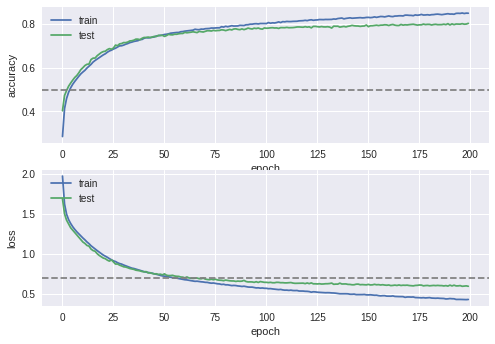

In [71]:
# summarize history for accuracy
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(histry.history['acc'])
plt.plot(histry.history['val_acc'])
plt.axhline(y=0.5, color='grey', linestyle='--')
#plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(histry.history['loss'])
plt.plot(histry.history['val_loss'])
plt.axhline(y=0.693, color='grey', linestyle='--')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('learning_curve_Resnetv2.png', bbox_inches='tight')

## Observation and Discussion 

In this section I showed a ResnetV2 implementation and I implemented it as shown in the paper [1]. A data augemntation generator was used to randomly shift and flip the images and add some whiting noise. The Resnet architecture is of 20 layers deep of total number of parmeter about 500K+. Using the GPU on this machine, It took about 40 seconds on average for every epoch. 200 Epoches were run and the best run achieved 90.8 % accuracy on the validation set. It is worth to mention that I ran the same algorithim on my 4 quad mahcine (no GPU) which took about 25 hours on 120 epoches to run and it achieved 92% accuracy. I guess this 1 percent discripency is due to the random weights intialized so a seed setup should be applied to make the results more replicatable. It looks like deep arcitectures in general achieves a good job than the simple conv net. The next sectoin will discribe my research path from here. We can either get deeper with the archtecture or think of ways to optimize the model. 

# Now Whats Next ?

There are plenty of aproaches to try but the time and resources are limted so let us take a step back and observe what was done so far and decide what are our next steps for this short study.  From the previous sections we showed a very complicated architecture such as resnet that gave fairly good results and also a very simple model that also showed reletively good results. The resnet-20 has 574,090 parameters and the convnet has much fewers parmas to train. Even though resnet showed better results but the comparison between performances is not fair. Both approaches were run on mean subtracted and pixel normalized data but the convolution net approach did not run using a learning rate scheduler, and the data agmentation generator was not applied too. I do not think it will surpase the performance of the resnet but it should improve the performance of the conv net approach. For the sake of completion I shall do that as my next step. Generaly, research papers show [1],[2],[3] that the deeper the model the better the results of the image classifcaitons. This is true but does that mean that simplier architectures are bad and we should not use them at all ? Also How much difference of accuracy performance are we gaining from deeper models and what is the time complexity trade off ? 

Now what I can try next can either be a more deeper architecture and try to reach to 95% accuracy by using a ResnetV2 of 1001 in depth or any other deep and complex architecture, then train it for like 5 days so I can only gain 3 %  -5 % extra accuracy or 27 hours using 2 GPUs [1]. On the other hand, we can try different approaches and try to reach to similar results with much less computational complexity trading off little accuracy perfromance. Neither approaches are wrong or right but it depends on the business problem or the application we have in hand. Since this is just a take home exam, I will try to use simpler models of different architectures to explore diversity.

The previous models are based on the traditional way of computing convolution but there are other reasnably deep approaches that uses what is called Deepth Seprable Convolution. This will perform a spatial convolution while keeping the channels (3 channels in case of RBG images) separate and then follow with a depthwise convolution. For more information about how depthwise convolutin work please have a look at [4]. The advantage of using deepth seprable convolution is that It cuts the number of multiplications by a factor of 9 in a convolution net compared to the standard convolution with a little comprimise on accuracy as shown in mobileNet architecture. 

There are lots of models I would love to try but I think I will choose the Xception architecture, a convolutional neural network architecture based entirely on depthwise separable convolution layers. The Xception architecture has 36 convolutional layers forming the feature extraction base of the network.  The 36 convolutional layers are structured into 14 modules, all of which have linear residual connections around them, except for the first and last modules. In short, the Xception architecture is a linear stack of depthwise separable convolution layers with residual skip connection [5]. It is inspired by the inception model and basically an extension of the Inception architecture which replaces the standard Inception modules with depthwise separable convolutions.

In the next sections I will redo the simple convolution approach one more time with data agmentation and a call back function. Also I will show the results of the xception model using a keras implementation. 


# ConvNet with Data Agumentation and Adaptable Learning Rate: 

The following code implements a similar simple conv net architecture to the one I tried before. For the sake of completness I wanted to run the same model using data augmentation and see if there are any changes in the results. Even though all the papers agrees that deep architectures achieves higher accuracy but I wanted to quantify how much improvements they mean by that, also its is worth to mention that most of the papers out there use the image net data set as a bench mark which is a different dataset used in this study. 

Things I tried that is not in the following code: 
 
 - If you notice the difference in architecture between this implementation and the previous one, you will notice that I added an extra layer of 128 filter size and an extra dropout. The result of both archiectures are very similar only 0.5% difference so it didnt really create a considrable significant change. 
 
 - I also tried taking z transform (mean subtraction then divide by standard diviation) to normalize the data to unit distribution but again I did not notice a big change in the results either. 


## Model

In [3]:
# retrain model or use saved model
retrain_convnet_augmentation = True
#save model_after_train 
model_name_conv_agmentation = 'convnet_augmentation_trained.h5'
# Data augmentation 
data_augmentation = True
# Training parameters
batch_size = 256
epochs = 200

# Reload data again this time try z-score instead of regular way of normalization
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train =  keras.utils.to_categorical(y_train,num_classes)
y_test =  keras.utils.to_categorical(y_test,num_classes)

170508288/170498071 [==============================] - 34s 0us/step


In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4), input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3),padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))  
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))  
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms,metrics=['accuracy'])

save_dir = os.path.join(os.getcwd(), 'saved_models')
m_name2 = 'convnet_agmentation_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, m_name2)
# callbacks for best saved models and for learning rates
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1,save_best_only=True)
lr_scheduler = LearningRateScheduler(learning_rate_adjuster)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [14]:
if retrain_convnet_augmentation: 
  histry = model.fit_generator(datagenerator.flow(x_train, y_train, batch_size=batch_size),
                            validation_data=(x_test, y_test),
                            epochs=epochs, verbose=1,
                            callbacks=[LearningRateScheduler(lr_schedule)])
  model = histry.model
  model.save_weights(save_dir+model_name_conv_agmentation)
else:
  model.load_weights(save_dir+model_name_conv_agmentation)
  print ('Model weights loaded')

Epoch 1/200
196/196 [==============================] - 44s 224ms/step - loss: 1.9714 - acc: 0.3674 - val_loss: 1.6754 - val_acc: 0.4845

Epoch 00001: val_acc improved from -inf to 0.48450, saving model to /content/saved_models/convnet_agmentation_20_model.001.h5
Epoch 2/200
196/196 [==============================] - 36s 184ms/step - loss: 1.4971 - acc: 0.4973 - val_loss: 1.3510 - val_acc: 0.5894

Epoch 00002: val_acc improved from 0.48450 to 0.58940, saving model to /content/saved_models/convnet_agmentation_20_model.002.h5
Epoch 3/200
 17/196 [=>............................] - ETA: 25s - loss: 1.3625 - acc: 0.5377

196/196 [==============================] - 37s 186ms/step - loss: 1.3096 - acc: 0.5616 - val_loss: 1.1570 - val_acc: 0.6443

Epoch 00003: val_acc improved from 0.58940 to 0.64430, saving model to /content/saved_models/convnet_agmentation_20_model.003.h5
Epoch 4/200
196/196 [==============================] - 36s 185ms/step - loss: 1.2208 - acc: 0.5894 - val_loss: 1.1776 - val_acc: 0.6380

Epoch 00004: val_acc did not improve from 0.64430
Epoch 5/200
 32/196 [===>..........................] - ETA: 25s - loss: 1.1916 - acc: 0.6040

196/196 [==============================] - 36s 186ms/step - loss: 1.1656 - acc: 0.6127 - val_loss: 1.1108 - val_acc: 0.6476

Epoch 00005: val_acc improved from 0.64430 to 0.64760, saving model to /content/saved_models/convnet_agmentation_20_model.005.h5
Epoch 6/200
196/196 [==============================] - 36s 185ms/step - loss: 1.1167 - acc: 0.6302 - val_loss: 1.0616 - val_acc: 0.6651

Epoch 00006: val_acc improved from 0.64760 to 0.66510, saving model to /content/saved_models/convnet_agmentation_20_model.006.h5
Epoch 7/200
 28/196 [===>..........................] - ETA: 24s - loss: 1.0877 - acc: 0.6449

196/196 [==============================] - 36s 186ms/step - loss: 1.0893 - acc: 0.6401 - val_loss: 0.9732 - val_acc: 0.6893

Epoch 00007: val_acc improved from 0.66510 to 0.68930, saving model to /content/saved_models/convnet_agmentation_20_model.007.h5
Epoch 8/200
196/196 [==============================] - 37s 187ms/step - loss: 1.0611 - acc: 0.6516 - val_loss: 0.9290 - val_acc: 0.7076

Epoch 00008: val_acc improved from 0.68930 to 0.70760, saving model to /content/saved_models/convnet_agmentation_20_model.008.h5
Epoch 9/200
 27/196 [===>..........................] - ETA: 25s - loss: 1.0247 - acc: 0.6569

196/196 [==============================] - 37s 187ms/step - loss: 1.0394 - acc: 0.6580 - val_loss: 1.0440 - val_acc: 0.6751

Epoch 00009: val_acc did not improve from 0.70760
Epoch 10/200
196/196 [==============================] - 37s 187ms/step - loss: 1.0250 - acc: 0.6664 - val_loss: 0.8664 - val_acc: 0.7287

Epoch 00010: val_acc improved from 0.70760 to 0.72870, saving model to /content/saved_models/convnet_agmentation_20_model.010.h5
Epoch 11/200
 58/196 [=======>......................] - ETA: 23s - loss: 1.0138 - acc: 0.6742

196/196 [==============================] - 36s 185ms/step - loss: 1.0079 - acc: 0.6742 - val_loss: 0.9520 - val_acc: 0.7082

Epoch 00011: val_acc did not improve from 0.72870
Epoch 12/200
196/196 [==============================] - 37s 187ms/step - loss: 0.9899 - acc: 0.6789 - val_loss: 0.8598 - val_acc: 0.7346

Epoch 00012: val_acc improved from 0.72870 to 0.73460, saving model to /content/saved_models/convnet_agmentation_20_model.012.h5
Epoch 13/200
 66/196 [=========>....................] - ETA: 22s - loss: 0.9851 - acc: 0.6827

196/196 [==============================] - 36s 185ms/step - loss: 0.9830 - acc: 0.6832 - val_loss: 0.8987 - val_acc: 0.7222

Epoch 00013: val_acc did not improve from 0.73460
Epoch 14/200
196/196 [==============================] - 37s 187ms/step - loss: 0.9731 - acc: 0.6852 - val_loss: 0.9360 - val_acc: 0.7108

Epoch 00014: val_acc did not improve from 0.73460
Epoch 15/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.9575 - acc: 0.6922

196/196 [==============================] - 37s 187ms/step - loss: 0.9601 - acc: 0.6922 - val_loss: 0.8635 - val_acc: 0.7316

Epoch 00015: val_acc did not improve from 0.73460
Epoch 16/200
196/196 [==============================] - 37s 189ms/step - loss: 0.9482 - acc: 0.6950 - val_loss: 0.8584 - val_acc: 0.7324

Epoch 00016: val_acc did not improve from 0.73460
Epoch 17/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.9427 - acc: 0.6944

196/196 [==============================] - 37s 191ms/step - loss: 0.9406 - acc: 0.6965 - val_loss: 0.9051 - val_acc: 0.7245

Epoch 00017: val_acc did not improve from 0.73460
Epoch 18/200
196/196 [==============================] - 37s 189ms/step - loss: 0.9356 - acc: 0.7018 - val_loss: 0.8488 - val_acc: 0.7424

Epoch 00018: val_acc improved from 0.73460 to 0.74240, saving model to /content/saved_models/convnet_agmentation_20_model.018.h5
Epoch 19/200
 67/196 [=========>....................] - ETA: 22s - loss: 0.9194 - acc: 0.7055

196/196 [==============================] - 37s 188ms/step - loss: 0.9296 - acc: 0.7031 - val_loss: 0.8119 - val_acc: 0.7500

Epoch 00019: val_acc improved from 0.74240 to 0.75000, saving model to /content/saved_models/convnet_agmentation_20_model.019.h5
Epoch 20/200
196/196 [==============================] - 38s 194ms/step - loss: 0.9313 - acc: 0.7039 - val_loss: 0.8396 - val_acc: 0.7397

Epoch 00020: val_acc did not improve from 0.75000
Epoch 21/200
 36/196 [====>.........................] - ETA: 25s - loss: 0.9217 - acc: 0.7033

196/196 [==============================] - 37s 187ms/step - loss: 0.9154 - acc: 0.7085 - val_loss: 0.8067 - val_acc: 0.7581

Epoch 00021: val_acc improved from 0.75000 to 0.75810, saving model to /content/saved_models/convnet_agmentation_20_model.021.h5
Epoch 22/200
196/196 [==============================] - 36s 186ms/step - loss: 0.9178 - acc: 0.7092 - val_loss: 0.9743 - val_acc: 0.7038

Epoch 00022: val_acc did not improve from 0.75810
Epoch 23/200
 34/196 [====>.........................] - ETA: 26s - loss: 0.8879 - acc: 0.7151

196/196 [==============================] - 37s 188ms/step - loss: 0.9042 - acc: 0.7111 - val_loss: 0.8744 - val_acc: 0.7346

Epoch 00023: val_acc did not improve from 0.75810
Epoch 24/200
196/196 [==============================] - 37s 187ms/step - loss: 0.9028 - acc: 0.7154 - val_loss: 0.9206 - val_acc: 0.7189

Epoch 00024: val_acc did not improve from 0.75810
Epoch 25/200
 73/196 [==========>...................] - ETA: 21s - loss: 0.9053 - acc: 0.7124

196/196 [==============================] - 37s 187ms/step - loss: 0.8992 - acc: 0.7154 - val_loss: 0.8003 - val_acc: 0.7580

Epoch 00025: val_acc did not improve from 0.75810
Epoch 26/200
196/196 [==============================] - 37s 188ms/step - loss: 0.9018 - acc: 0.7141 - val_loss: 0.7749 - val_acc: 0.7669

Epoch 00026: val_acc improved from 0.75810 to 0.76690, saving model to /content/saved_models/convnet_agmentation_20_model.026.h5
Epoch 27/200
 67/196 [=========>....................] - ETA: 21s - loss: 0.8883 - acc: 0.7211

196/196 [==============================] - 37s 187ms/step - loss: 0.8965 - acc: 0.7174 - val_loss: 0.8379 - val_acc: 0.7429

Epoch 00027: val_acc did not improve from 0.76690
Epoch 28/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8896 - acc: 0.7213 - val_loss: 0.7814 - val_acc: 0.7633

Epoch 00028: val_acc did not improve from 0.76690
Epoch 29/200
 76/196 [==========>...................] - ETA: 20s - loss: 0.8810 - acc: 0.7191

196/196 [==============================] - 37s 187ms/step - loss: 0.8929 - acc: 0.7173 - val_loss: 0.8122 - val_acc: 0.7551

Epoch 00029: val_acc did not improve from 0.76690
Epoch 30/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8859 - acc: 0.7234 - val_loss: 0.9108 - val_acc: 0.7272

Epoch 00030: val_acc did not improve from 0.76690
Epoch 31/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.8856 - acc: 0.7239

196/196 [==============================] - 36s 186ms/step - loss: 0.8883 - acc: 0.7234 - val_loss: 0.8272 - val_acc: 0.7494

Epoch 00031: val_acc did not improve from 0.76690
Epoch 32/200
196/196 [==============================] - 36s 185ms/step - loss: 0.8799 - acc: 0.7245 - val_loss: 0.8644 - val_acc: 0.7442

Epoch 00032: val_acc did not improve from 0.76690
Epoch 33/200
 82/196 [===========>..................] - ETA: 19s - loss: 0.8832 - acc: 0.7262

196/196 [==============================] - 37s 186ms/step - loss: 0.8826 - acc: 0.7247 - val_loss: 0.8774 - val_acc: 0.7425

Epoch 00033: val_acc did not improve from 0.76690
Epoch 34/200
196/196 [==============================] - 36s 186ms/step - loss: 0.8828 - acc: 0.7255 - val_loss: 0.8794 - val_acc: 0.7378

Epoch 00034: val_acc did not improve from 0.76690
Epoch 35/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.8790 - acc: 0.7259

196/196 [==============================] - 36s 186ms/step - loss: 0.8807 - acc: 0.7260 - val_loss: 0.8366 - val_acc: 0.7481

Epoch 00035: val_acc did not improve from 0.76690
Epoch 36/200
196/196 [==============================] - 36s 185ms/step - loss: 0.8740 - acc: 0.7268 - val_loss: 0.8137 - val_acc: 0.7564

Epoch 00036: val_acc did not improve from 0.76690
Epoch 37/200
 82/196 [===========>..................] - ETA: 19s - loss: 0.8739 - acc: 0.7294

196/196 [==============================] - 37s 187ms/step - loss: 0.8747 - acc: 0.7271 - val_loss: 0.7445 - val_acc: 0.7764

Epoch 00037: val_acc improved from 0.76690 to 0.77640, saving model to /content/saved_models/convnet_agmentation_20_model.037.h5
Epoch 38/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8704 - acc: 0.7292 - val_loss: 0.7948 - val_acc: 0.7650

Epoch 00038: val_acc did not improve from 0.77640
Epoch 39/200
 39/196 [====>.........................] - ETA: 25s - loss: 0.8721 - acc: 0.7284

196/196 [==============================] - 37s 187ms/step - loss: 0.8693 - acc: 0.7306 - val_loss: 0.7809 - val_acc: 0.7676

Epoch 00039: val_acc did not improve from 0.77640
Epoch 40/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8668 - acc: 0.7320 - val_loss: 0.8422 - val_acc: 0.7470

Epoch 00040: val_acc did not improve from 0.77640
Epoch 41/200
 67/196 [=========>....................] - ETA: 22s - loss: 0.8660 - acc: 0.7315

196/196 [==============================] - 37s 187ms/step - loss: 0.8681 - acc: 0.7322 - val_loss: 0.7749 - val_acc: 0.7748

Epoch 00041: val_acc did not improve from 0.77640
Epoch 42/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8694 - acc: 0.7315 - val_loss: 0.7745 - val_acc: 0.7722

Epoch 00042: val_acc did not improve from 0.77640
Epoch 43/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.8514 - acc: 0.7381

196/196 [==============================] - 37s 188ms/step - loss: 0.8605 - acc: 0.7330 - val_loss: 0.7590 - val_acc: 0.7798

Epoch 00043: val_acc improved from 0.77640 to 0.77980, saving model to /content/saved_models/convnet_agmentation_20_model.043.h5
Epoch 44/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8647 - acc: 0.7336 - val_loss: 0.8815 - val_acc: 0.7483

Epoch 00044: val_acc did not improve from 0.77980
Epoch 45/200
 39/196 [====>.........................] - ETA: 25s - loss: 0.8525 - acc: 0.7389

196/196 [==============================] - 37s 188ms/step - loss: 0.8680 - acc: 0.7335 - val_loss: 0.7867 - val_acc: 0.7669

Epoch 00045: val_acc did not improve from 0.77980
Epoch 46/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8607 - acc: 0.7332 - val_loss: 0.7714 - val_acc: 0.7717

Epoch 00046: val_acc did not improve from 0.77980
Epoch 47/200
 74/196 [==========>...................] - ETA: 21s - loss: 0.8514 - acc: 0.7372

196/196 [==============================] - 37s 187ms/step - loss: 0.8598 - acc: 0.7352 - val_loss: 0.8822 - val_acc: 0.7399

Epoch 00047: val_acc did not improve from 0.77980
Epoch 48/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8604 - acc: 0.7323 - val_loss: 0.7771 - val_acc: 0.7729

Epoch 00048: val_acc did not improve from 0.77980
Epoch 49/200
 78/196 [==========>...................] - ETA: 20s - loss: 0.8598 - acc: 0.7373

196/196 [==============================] - 37s 187ms/step - loss: 0.8581 - acc: 0.7385 - val_loss: 0.7338 - val_acc: 0.7853

Epoch 00049: val_acc improved from 0.77980 to 0.78530, saving model to /content/saved_models/convnet_agmentation_20_model.049.h5
Epoch 50/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8498 - acc: 0.7380 - val_loss: 0.7605 - val_acc: 0.7737

Epoch 00050: val_acc did not improve from 0.78530
Epoch 51/200
 40/196 [=====>........................] - ETA: 25s - loss: 0.8367 - acc: 0.7480

196/196 [==============================] - 37s 187ms/step - loss: 0.8597 - acc: 0.7371 - val_loss: 0.8091 - val_acc: 0.7608

Epoch 00051: val_acc did not improve from 0.78530
Epoch 52/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8542 - acc: 0.7391 - val_loss: 0.8562 - val_acc: 0.7496

Epoch 00052: val_acc did not improve from 0.78530
Epoch 53/200
 75/196 [==========>...................] - ETA: 20s - loss: 0.8433 - acc: 0.7417

196/196 [==============================] - 37s 187ms/step - loss: 0.8527 - acc: 0.7382 - val_loss: 0.7474 - val_acc: 0.7842

Epoch 00053: val_acc did not improve from 0.78530
Epoch 54/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8542 - acc: 0.7383 - val_loss: 0.7737 - val_acc: 0.7752

Epoch 00054: val_acc did not improve from 0.78530
Epoch 55/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.8427 - acc: 0.7423

196/196 [==============================] - 37s 187ms/step - loss: 0.8499 - acc: 0.7392 - val_loss: 0.7416 - val_acc: 0.7822

Epoch 00055: val_acc did not improve from 0.78530
Epoch 56/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8489 - acc: 0.7393 - val_loss: 0.8083 - val_acc: 0.7586

Epoch 00056: val_acc did not improve from 0.78530
Epoch 57/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.8449 - acc: 0.7408

196/196 [==============================] - 37s 186ms/step - loss: 0.8497 - acc: 0.7396 - val_loss: 0.8131 - val_acc: 0.7653

Epoch 00057: val_acc did not improve from 0.78530
Epoch 58/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8402 - acc: 0.7423 - val_loss: 0.7373 - val_acc: 0.7784

Epoch 00058: val_acc did not improve from 0.78530
Epoch 59/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.8430 - acc: 0.7413

196/196 [==============================] - 37s 187ms/step - loss: 0.8500 - acc: 0.7396 - val_loss: 0.8145 - val_acc: 0.7622

Epoch 00059: val_acc did not improve from 0.78530
Epoch 60/200
196/196 [==============================] - 37s 186ms/step - loss: 0.8456 - acc: 0.7410 - val_loss: 0.7883 - val_acc: 0.7692

Epoch 00060: val_acc did not improve from 0.78530
Epoch 61/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.8441 - acc: 0.7395

196/196 [==============================] - 37s 187ms/step - loss: 0.8447 - acc: 0.7405 - val_loss: 0.7666 - val_acc: 0.7752

Epoch 00061: val_acc did not improve from 0.78530
Epoch 62/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8437 - acc: 0.7426 - val_loss: 0.7419 - val_acc: 0.7825

Epoch 00062: val_acc did not improve from 0.78530
Epoch 63/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.8441 - acc: 0.7386

196/196 [==============================] - 37s 187ms/step - loss: 0.8458 - acc: 0.7393 - val_loss: 0.8602 - val_acc: 0.7425

Epoch 00063: val_acc did not improve from 0.78530
Epoch 64/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8375 - acc: 0.7413 - val_loss: 0.7531 - val_acc: 0.7818

Epoch 00064: val_acc did not improve from 0.78530
Epoch 65/200
 83/196 [===========>..................] - ETA: 19s - loss: 0.8384 - acc: 0.7468

196/196 [==============================] - 37s 187ms/step - loss: 0.8387 - acc: 0.7453 - val_loss: 0.7401 - val_acc: 0.7820

Epoch 00065: val_acc did not improve from 0.78530
Epoch 66/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8389 - acc: 0.7446 - val_loss: 0.7846 - val_acc: 0.7669

Epoch 00066: val_acc did not improve from 0.78530
Epoch 67/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.8398 - acc: 0.7440

196/196 [==============================] - 37s 188ms/step - loss: 0.8421 - acc: 0.7428 - val_loss: 0.7707 - val_acc: 0.7771

Epoch 00067: val_acc did not improve from 0.78530
Epoch 68/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8393 - acc: 0.7455 - val_loss: 0.7532 - val_acc: 0.7769

Epoch 00068: val_acc did not improve from 0.78530
Epoch 69/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.8376 - acc: 0.7422

196/196 [==============================] - 37s 188ms/step - loss: 0.8424 - acc: 0.7429 - val_loss: 0.7785 - val_acc: 0.7730

Epoch 00069: val_acc did not improve from 0.78530
Epoch 70/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8371 - acc: 0.7470 - val_loss: 0.7812 - val_acc: 0.7701

Epoch 00070: val_acc did not improve from 0.78530
Epoch 71/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.8298 - acc: 0.7460

196/196 [==============================] - 37s 188ms/step - loss: 0.8421 - acc: 0.7422 - val_loss: 0.7091 - val_acc: 0.7933

Epoch 00071: val_acc improved from 0.78530 to 0.79330, saving model to /content/saved_models/convnet_agmentation_20_model.071.h5
Epoch 72/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8348 - acc: 0.7465 - val_loss: 0.7550 - val_acc: 0.7798

Epoch 00072: val_acc did not improve from 0.79330
Epoch 73/200
 40/196 [=====>........................] - ETA: 25s - loss: 0.8458 - acc: 0.7382

196/196 [==============================] - 37s 187ms/step - loss: 0.8407 - acc: 0.7426 - val_loss: 0.7340 - val_acc: 0.7881

Epoch 00073: val_acc did not improve from 0.79330
Epoch 74/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8396 - acc: 0.7451 - val_loss: 0.7741 - val_acc: 0.7769

Epoch 00074: val_acc did not improve from 0.79330
Epoch 75/200
 69/196 [=========>....................] - ETA: 22s - loss: 0.8372 - acc: 0.7462

196/196 [==============================] - 37s 188ms/step - loss: 0.8347 - acc: 0.7451 - val_loss: 0.7119 - val_acc: 0.7886

Epoch 00075: val_acc did not improve from 0.79330
Epoch 76/200
196/196 [==============================] - 37s 187ms/step - loss: 0.8403 - acc: 0.7462 - val_loss: 0.8542 - val_acc: 0.7517

Epoch 00076: val_acc did not improve from 0.79330
Epoch 77/200
 81/196 [===========>..................] - ETA: 19s - loss: 0.8372 - acc: 0.7471

196/196 [==============================] - 37s 188ms/step - loss: 0.8340 - acc: 0.7465 - val_loss: 0.8401 - val_acc: 0.7568

Epoch 00077: val_acc did not improve from 0.79330
Epoch 78/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8298 - acc: 0.7465 - val_loss: 0.7518 - val_acc: 0.7787

Epoch 00078: val_acc did not improve from 0.79330
Epoch 79/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.8306 - acc: 0.7513

196/196 [==============================] - 37s 188ms/step - loss: 0.8338 - acc: 0.7477 - val_loss: 0.7946 - val_acc: 0.7668

Epoch 00079: val_acc did not improve from 0.79330
Epoch 80/200
196/196 [==============================] - 37s 188ms/step - loss: 0.8296 - acc: 0.7492 - val_loss: 0.7509 - val_acc: 0.7827

Epoch 00080: val_acc did not improve from 0.79330
Epoch 81/200
 78/196 [==========>...................] - ETA: 20s - loss: 0.8262 - acc: 0.7472

196/196 [==============================] - 37s 188ms/step - loss: 0.8347 - acc: 0.7447 - val_loss: 0.7239 - val_acc: 0.7819

Epoch 00081: val_acc did not improve from 0.79330
Epoch 82/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7918 - acc: 0.7608 - val_loss: 0.7047 - val_acc: 0.7940

Epoch 00082: val_acc improved from 0.79330 to 0.79400, saving model to /content/saved_models/convnet_agmentation_20_model.082.h5
Epoch 83/200
 66/196 [=========>....................] - ETA: 22s - loss: 0.7709 - acc: 0.7680

196/196 [==============================] - 37s 187ms/step - loss: 0.7741 - acc: 0.7664 - val_loss: 0.6935 - val_acc: 0.7978

Epoch 00083: val_acc improved from 0.79400 to 0.79780, saving model to /content/saved_models/convnet_agmentation_20_model.083.h5
Epoch 84/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7682 - acc: 0.7697 - val_loss: 0.7066 - val_acc: 0.7944

Epoch 00084: val_acc did not improve from 0.79780
Epoch 85/200
 34/196 [====>.........................] - ETA: 26s - loss: 0.7711 - acc: 0.7678

196/196 [==============================] - 37s 188ms/step - loss: 0.7638 - acc: 0.7695 - val_loss: 0.6855 - val_acc: 0.8000

Epoch 00085: val_acc improved from 0.79780 to 0.80000, saving model to /content/saved_models/convnet_agmentation_20_model.085.h5
Epoch 86/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7647 - acc: 0.7696 - val_loss: 0.6714 - val_acc: 0.8013

Epoch 00086: val_acc improved from 0.80000 to 0.80130, saving model to /content/saved_models/convnet_agmentation_20_model.086.h5
Epoch 87/200
 25/196 [==>...........................] - ETA: 24s - loss: 0.7281 - acc: 0.7832

196/196 [==============================] - 37s 188ms/step - loss: 0.7578 - acc: 0.7705 - val_loss: 0.6945 - val_acc: 0.7972

Epoch 00087: val_acc did not improve from 0.80130
Epoch 88/200
196/196 [==============================] - 36s 186ms/step - loss: 0.7584 - acc: 0.7713 - val_loss: 0.6879 - val_acc: 0.7976

Epoch 00088: val_acc did not improve from 0.80130
Epoch 89/200
 71/196 [=========>....................] - ETA: 21s - loss: 0.7565 - acc: 0.7710

196/196 [==============================] - 37s 188ms/step - loss: 0.7531 - acc: 0.7727 - val_loss: 0.6822 - val_acc: 0.8007

Epoch 00089: val_acc did not improve from 0.80130
Epoch 90/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7541 - acc: 0.7720 - val_loss: 0.6752 - val_acc: 0.8040

Epoch 00090: val_acc improved from 0.80130 to 0.80400, saving model to /content/saved_models/convnet_agmentation_20_model.090.h5
Epoch 91/200
 67/196 [=========>....................] - ETA: 21s - loss: 0.7457 - acc: 0.7748

196/196 [==============================] - 37s 187ms/step - loss: 0.7495 - acc: 0.7746 - val_loss: 0.6729 - val_acc: 0.8017

Epoch 00091: val_acc did not improve from 0.80400
Epoch 92/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7471 - acc: 0.7748 - val_loss: 0.6844 - val_acc: 0.8015

Epoch 00092: val_acc did not improve from 0.80400
Epoch 93/200
 77/196 [==========>...................] - ETA: 20s - loss: 0.7483 - acc: 0.7736

196/196 [==============================] - 37s 188ms/step - loss: 0.7442 - acc: 0.7759 - val_loss: 0.6764 - val_acc: 0.8029

Epoch 00093: val_acc did not improve from 0.80400
Epoch 94/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7411 - acc: 0.7766 - val_loss: 0.6574 - val_acc: 0.8074

Epoch 00094: val_acc improved from 0.80400 to 0.80740, saving model to /content/saved_models/convnet_agmentation_20_model.094.h5
Epoch 95/200
 65/196 [========>.....................] - ETA: 22s - loss: 0.7572 - acc: 0.7718

196/196 [==============================] - 37s 188ms/step - loss: 0.7398 - acc: 0.7772 - val_loss: 0.6797 - val_acc: 0.8038

Epoch 00095: val_acc did not improve from 0.80740
Epoch 96/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7423 - acc: 0.7753 - val_loss: 0.6750 - val_acc: 0.8019

Epoch 00096: val_acc did not improve from 0.80740
Epoch 97/200
 74/196 [==========>...................] - ETA: 21s - loss: 0.7540 - acc: 0.7719

196/196 [==============================] - 37s 187ms/step - loss: 0.7453 - acc: 0.7752 - val_loss: 0.6554 - val_acc: 0.8045

Epoch 00097: val_acc did not improve from 0.80740
Epoch 98/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7394 - acc: 0.7764 - val_loss: 0.6922 - val_acc: 0.7978

Epoch 00098: val_acc did not improve from 0.80740
Epoch 99/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.7312 - acc: 0.7768

196/196 [==============================] - 38s 192ms/step - loss: 0.7324 - acc: 0.7775 - val_loss: 0.6556 - val_acc: 0.8067

Epoch 00099: val_acc did not improve from 0.80740
Epoch 100/200
196/196 [==============================] - 36s 185ms/step - loss: 0.7362 - acc: 0.7770 - val_loss: 0.6718 - val_acc: 0.8022

Epoch 00100: val_acc did not improve from 0.80740
Epoch 101/200
 82/196 [===========>..................] - ETA: 19s - loss: 0.7404 - acc: 0.7756

196/196 [==============================] - 37s 187ms/step - loss: 0.7370 - acc: 0.7761 - val_loss: 0.6703 - val_acc: 0.8042

Epoch 00101: val_acc did not improve from 0.80740
Epoch 102/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7357 - acc: 0.7770 - val_loss: 0.6673 - val_acc: 0.8048

Epoch 00102: val_acc did not improve from 0.80740
Epoch 103/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7317 - acc: 0.7783

196/196 [==============================] - 37s 187ms/step - loss: 0.7337 - acc: 0.7777 - val_loss: 0.6659 - val_acc: 0.8038

Epoch 00103: val_acc did not improve from 0.80740
Epoch 104/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7295 - acc: 0.7778 - val_loss: 0.6725 - val_acc: 0.8031

Epoch 00104: val_acc did not improve from 0.80740
Epoch 105/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7332 - acc: 0.7762

196/196 [==============================] - 37s 187ms/step - loss: 0.7298 - acc: 0.7770 - val_loss: 0.6580 - val_acc: 0.8066

Epoch 00105: val_acc did not improve from 0.80740
Epoch 106/200
196/196 [==============================] - 36s 186ms/step - loss: 0.7238 - acc: 0.7813 - val_loss: 0.6591 - val_acc: 0.8060

Epoch 00106: val_acc did not improve from 0.80740
Epoch 107/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7291 - acc: 0.7813

196/196 [==============================] - 37s 187ms/step - loss: 0.7266 - acc: 0.7795 - val_loss: 0.6641 - val_acc: 0.8044

Epoch 00107: val_acc did not improve from 0.80740
Epoch 108/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7240 - acc: 0.7800 - val_loss: 0.6629 - val_acc: 0.8057

Epoch 00108: val_acc did not improve from 0.80740
Epoch 109/200
 78/196 [==========>...................] - ETA: 20s - loss: 0.7267 - acc: 0.7778

196/196 [==============================] - 37s 187ms/step - loss: 0.7264 - acc: 0.7795 - val_loss: 0.6476 - val_acc: 0.8085

Epoch 00109: val_acc improved from 0.80740 to 0.80850, saving model to /content/saved_models/convnet_agmentation_20_model.109.h5
Epoch 110/200
196/196 [==============================] - 37s 186ms/step - loss: 0.7215 - acc: 0.7797 - val_loss: 0.6873 - val_acc: 0.8002

Epoch 00110: val_acc did not improve from 0.80850
Epoch 111/200
 39/196 [====>.........................] - ETA: 25s - loss: 0.7299 - acc: 0.7771

196/196 [==============================] - 37s 188ms/step - loss: 0.7239 - acc: 0.7811 - val_loss: 0.6736 - val_acc: 0.8004

Epoch 00111: val_acc did not improve from 0.80850
Epoch 112/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7189 - acc: 0.7835 - val_loss: 0.6509 - val_acc: 0.8066

Epoch 00112: val_acc did not improve from 0.80850
Epoch 113/200
 71/196 [=========>....................] - ETA: 21s - loss: 0.7268 - acc: 0.7771

196/196 [==============================] - 37s 188ms/step - loss: 0.7231 - acc: 0.7801 - val_loss: 0.6620 - val_acc: 0.8056

Epoch 00113: val_acc did not improve from 0.80850
Epoch 114/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7242 - acc: 0.7790 - val_loss: 0.6561 - val_acc: 0.8071

Epoch 00114: val_acc did not improve from 0.80850
Epoch 115/200
 77/196 [==========>...................] - ETA: 20s - loss: 0.7129 - acc: 0.7812

196/196 [==============================] - 37s 187ms/step - loss: 0.7190 - acc: 0.7806 - val_loss: 0.6516 - val_acc: 0.8075

Epoch 00115: val_acc did not improve from 0.80850
Epoch 116/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7210 - acc: 0.7791 - val_loss: 0.6721 - val_acc: 0.8010

Epoch 00116: val_acc did not improve from 0.80850
Epoch 117/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.7056 - acc: 0.7852

196/196 [==============================] - 37s 187ms/step - loss: 0.7148 - acc: 0.7811 - val_loss: 0.6219 - val_acc: 0.8163

Epoch 00117: val_acc improved from 0.80850 to 0.81630, saving model to /content/saved_models/convnet_agmentation_20_model.117.h5
Epoch 118/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7150 - acc: 0.7826 - val_loss: 0.6480 - val_acc: 0.8074

Epoch 00118: val_acc did not improve from 0.81630
Epoch 119/200
 38/196 [====>.........................] - ETA: 25s - loss: 0.7219 - acc: 0.7835

196/196 [==============================] - 37s 188ms/step - loss: 0.7204 - acc: 0.7788 - val_loss: 0.6559 - val_acc: 0.8060

Epoch 00119: val_acc did not improve from 0.81630
Epoch 120/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7171 - acc: 0.7827 - val_loss: 0.6575 - val_acc: 0.8082

Epoch 00120: val_acc did not improve from 0.81630
Epoch 121/200
 72/196 [==========>...................] - ETA: 21s - loss: 0.7095 - acc: 0.7843

196/196 [==============================] - 37s 188ms/step - loss: 0.7095 - acc: 0.7825 - val_loss: 0.6628 - val_acc: 0.8049

Epoch 00121: val_acc did not improve from 0.81630
Epoch 122/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7124 - acc: 0.7827 - val_loss: 0.6465 - val_acc: 0.8087

Epoch 00122: val_acc did not improve from 0.81630
Epoch 123/200
 77/196 [==========>...................] - ETA: 20s - loss: 0.7022 - acc: 0.7840

196/196 [==============================] - 37s 186ms/step - loss: 0.7050 - acc: 0.7841 - val_loss: 0.6438 - val_acc: 0.8098

Epoch 00123: val_acc did not improve from 0.81630
Epoch 124/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7054 - acc: 0.7861 - val_loss: 0.6447 - val_acc: 0.8092

Epoch 00124: val_acc did not improve from 0.81630
Epoch 125/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.7025 - acc: 0.7862

196/196 [==============================] - 37s 187ms/step - loss: 0.7092 - acc: 0.7847 - val_loss: 0.6474 - val_acc: 0.8081

Epoch 00125: val_acc did not improve from 0.81630
Epoch 126/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7096 - acc: 0.7839 - val_loss: 0.6475 - val_acc: 0.8094

Epoch 00126: val_acc did not improve from 0.81630
Epoch 127/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7167 - acc: 0.7824

196/196 [==============================] - 37s 187ms/step - loss: 0.7094 - acc: 0.7842 - val_loss: 0.6409 - val_acc: 0.8102

Epoch 00127: val_acc did not improve from 0.81630
Epoch 128/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7089 - acc: 0.7839 - val_loss: 0.6441 - val_acc: 0.8092

Epoch 00128: val_acc did not improve from 0.81630
Epoch 129/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7000 - acc: 0.7858

196/196 [==============================] - 37s 187ms/step - loss: 0.7035 - acc: 0.7862 - val_loss: 0.6419 - val_acc: 0.8094

Epoch 00129: val_acc did not improve from 0.81630
Epoch 130/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7099 - acc: 0.7826 - val_loss: 0.6449 - val_acc: 0.8075

Epoch 00130: val_acc did not improve from 0.81630
Epoch 131/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.6984 - acc: 0.7861

196/196 [==============================] - 37s 188ms/step - loss: 0.7084 - acc: 0.7837 - val_loss: 0.6434 - val_acc: 0.8094

Epoch 00131: val_acc did not improve from 0.81630
Epoch 132/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7037 - acc: 0.7847 - val_loss: 0.6436 - val_acc: 0.8098

Epoch 00132: val_acc did not improve from 0.81630
Epoch 133/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7138 - acc: 0.7818

196/196 [==============================] - 37s 188ms/step - loss: 0.7080 - acc: 0.7838 - val_loss: 0.6441 - val_acc: 0.8095

Epoch 00133: val_acc did not improve from 0.81630
Epoch 134/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7075 - acc: 0.7823 - val_loss: 0.6442 - val_acc: 0.8086

Epoch 00134: val_acc did not improve from 0.81630
Epoch 135/200
 77/196 [==========>...................] - ETA: 20s - loss: 0.7090 - acc: 0.7852

196/196 [==============================] - 37s 186ms/step - loss: 0.7075 - acc: 0.7841 - val_loss: 0.6486 - val_acc: 0.8079

Epoch 00135: val_acc did not improve from 0.81630
Epoch 136/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7017 - acc: 0.7867 - val_loss: 0.6489 - val_acc: 0.8086

Epoch 00136: val_acc did not improve from 0.81630
Epoch 137/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7029 - acc: 0.7847

196/196 [==============================] - 37s 187ms/step - loss: 0.7062 - acc: 0.7836 - val_loss: 0.6449 - val_acc: 0.8079

Epoch 00137: val_acc did not improve from 0.81630
Epoch 138/200
196/196 [==============================] - 36s 186ms/step - loss: 0.7039 - acc: 0.7843 - val_loss: 0.6434 - val_acc: 0.8090

Epoch 00138: val_acc did not improve from 0.81630
Epoch 139/200
 82/196 [===========>..................] - ETA: 19s - loss: 0.7024 - acc: 0.7851

196/196 [==============================] - 36s 186ms/step - loss: 0.7048 - acc: 0.7838 - val_loss: 0.6452 - val_acc: 0.8088

Epoch 00139: val_acc did not improve from 0.81630
Epoch 140/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7069 - acc: 0.7859 - val_loss: 0.6461 - val_acc: 0.8086

Epoch 00140: val_acc did not improve from 0.81630
Epoch 141/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7086 - acc: 0.7854

196/196 [==============================] - 37s 187ms/step - loss: 0.7077 - acc: 0.7835 - val_loss: 0.6416 - val_acc: 0.8093

Epoch 00141: val_acc did not improve from 0.81630
Epoch 142/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7038 - acc: 0.7841 - val_loss: 0.6428 - val_acc: 0.8099

Epoch 00142: val_acc did not improve from 0.81630
Epoch 143/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7034 - acc: 0.7841

196/196 [==============================] - 37s 187ms/step - loss: 0.7050 - acc: 0.7847 - val_loss: 0.6406 - val_acc: 0.8093

Epoch 00143: val_acc did not improve from 0.81630
Epoch 144/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7033 - acc: 0.7840 - val_loss: 0.6450 - val_acc: 0.8089

Epoch 00144: val_acc did not improve from 0.81630
Epoch 145/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7082 - acc: 0.7853

196/196 [==============================] - 37s 188ms/step - loss: 0.7023 - acc: 0.7871 - val_loss: 0.6474 - val_acc: 0.8081

Epoch 00145: val_acc did not improve from 0.81630
Epoch 146/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7043 - acc: 0.7846 - val_loss: 0.6499 - val_acc: 0.8088

Epoch 00146: val_acc did not improve from 0.81630
Epoch 147/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.6921 - acc: 0.7896

196/196 [==============================] - 37s 188ms/step - loss: 0.7040 - acc: 0.7852 - val_loss: 0.6458 - val_acc: 0.8085

Epoch 00147: val_acc did not improve from 0.81630
Epoch 148/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7004 - acc: 0.7867 - val_loss: 0.6455 - val_acc: 0.8083

Epoch 00148: val_acc did not improve from 0.81630
Epoch 149/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7002 - acc: 0.7881

196/196 [==============================] - 37s 188ms/step - loss: 0.7045 - acc: 0.7844 - val_loss: 0.6415 - val_acc: 0.8095

Epoch 00149: val_acc did not improve from 0.81630
Epoch 150/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7033 - acc: 0.7873 - val_loss: 0.6423 - val_acc: 0.8095

Epoch 00150: val_acc did not improve from 0.81630
Epoch 151/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.6986 - acc: 0.7847

196/196 [==============================] - 37s 186ms/step - loss: 0.7025 - acc: 0.7852 - val_loss: 0.6454 - val_acc: 0.8087

Epoch 00151: val_acc did not improve from 0.81630
Epoch 152/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7019 - acc: 0.7853 - val_loss: 0.6452 - val_acc: 0.8085

Epoch 00152: val_acc did not improve from 0.81630
Epoch 153/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7081 - acc: 0.7868

196/196 [==============================] - 37s 187ms/step - loss: 0.7071 - acc: 0.7864 - val_loss: 0.6434 - val_acc: 0.8085

Epoch 00153: val_acc did not improve from 0.81630
Epoch 154/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7018 - acc: 0.7869 - val_loss: 0.6415 - val_acc: 0.8093

Epoch 00154: val_acc did not improve from 0.81630
Epoch 155/200
 81/196 [===========>..................] - ETA: 19s - loss: 0.7004 - acc: 0.7878

196/196 [==============================] - 37s 187ms/step - loss: 0.7068 - acc: 0.7841 - val_loss: 0.6439 - val_acc: 0.8088

Epoch 00155: val_acc did not improve from 0.81630
Epoch 156/200
196/196 [==============================] - 37s 187ms/step - loss: 0.6965 - acc: 0.7884 - val_loss: 0.6420 - val_acc: 0.8090

Epoch 00156: val_acc did not improve from 0.81630
Epoch 157/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.7022 - acc: 0.7823

196/196 [==============================] - 37s 187ms/step - loss: 0.7033 - acc: 0.7845 - val_loss: 0.6423 - val_acc: 0.8092

Epoch 00157: val_acc did not improve from 0.81630
Epoch 158/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7032 - acc: 0.7858 - val_loss: 0.6430 - val_acc: 0.8094

Epoch 00158: val_acc did not improve from 0.81630
Epoch 159/200
 78/196 [==========>...................] - ETA: 20s - loss: 0.6974 - acc: 0.7883

196/196 [==============================] - 37s 187ms/step - loss: 0.7017 - acc: 0.7853 - val_loss: 0.6389 - val_acc: 0.8102

Epoch 00159: val_acc did not improve from 0.81630
Epoch 160/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7022 - acc: 0.7852 - val_loss: 0.6399 - val_acc: 0.8103

Epoch 00160: val_acc did not improve from 0.81630
Epoch 161/200
 80/196 [===========>..................] - ETA: 19s - loss: 0.6993 - acc: 0.7872

196/196 [==============================] - 37s 187ms/step - loss: 0.7020 - acc: 0.7853 - val_loss: 0.6370 - val_acc: 0.8105

Epoch 00161: val_acc did not improve from 0.81630
Epoch 162/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7041 - acc: 0.7839 - val_loss: 0.6375 - val_acc: 0.8104

Epoch 00162: val_acc did not improve from 0.81630
Epoch 163/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7037 - acc: 0.7850

196/196 [==============================] - 37s 187ms/step - loss: 0.7042 - acc: 0.7843 - val_loss: 0.6381 - val_acc: 0.8106

Epoch 00163: val_acc did not improve from 0.81630
Epoch 164/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7072 - acc: 0.7817 - val_loss: 0.6391 - val_acc: 0.8103

Epoch 00164: val_acc did not improve from 0.81630
Epoch 165/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7000 - acc: 0.7880

196/196 [==============================] - 37s 186ms/step - loss: 0.7017 - acc: 0.7857 - val_loss: 0.6396 - val_acc: 0.8101

Epoch 00165: val_acc did not improve from 0.81630
Epoch 166/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7033 - acc: 0.7853 - val_loss: 0.6393 - val_acc: 0.8098

Epoch 00166: val_acc did not improve from 0.81630
Epoch 167/200
 76/196 [==========>...................] - ETA: 20s - loss: 0.7034 - acc: 0.7859

196/196 [==============================] - 37s 188ms/step - loss: 0.7010 - acc: 0.7858 - val_loss: 0.6391 - val_acc: 0.8100

Epoch 00167: val_acc did not improve from 0.81630
Epoch 168/200
196/196 [==============================] - 37s 187ms/step - loss: 0.6994 - acc: 0.7837 - val_loss: 0.6396 - val_acc: 0.8100

Epoch 00168: val_acc did not improve from 0.81630
Epoch 169/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.6888 - acc: 0.7893

196/196 [==============================] - 37s 187ms/step - loss: 0.7025 - acc: 0.7860 - val_loss: 0.6395 - val_acc: 0.8100

Epoch 00169: val_acc did not improve from 0.81630
Epoch 170/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7026 - acc: 0.7840 - val_loss: 0.6393 - val_acc: 0.8101

Epoch 00170: val_acc did not improve from 0.81630
Epoch 171/200
 77/196 [==========>...................] - ETA: 20s - loss: 0.7015 - acc: 0.7831

196/196 [==============================] - 37s 188ms/step - loss: 0.7058 - acc: 0.7834 - val_loss: 0.6390 - val_acc: 0.8099

Epoch 00171: val_acc did not improve from 0.81630
Epoch 172/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7069 - acc: 0.7832 - val_loss: 0.6388 - val_acc: 0.8100

Epoch 00172: val_acc did not improve from 0.81630
Epoch 173/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.6955 - acc: 0.7900

196/196 [==============================] - 37s 187ms/step - loss: 0.7010 - acc: 0.7865 - val_loss: 0.6395 - val_acc: 0.8103

Epoch 00173: val_acc did not improve from 0.81630
Epoch 174/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7002 - acc: 0.7852 - val_loss: 0.6394 - val_acc: 0.8102

Epoch 00174: val_acc did not improve from 0.81630
Epoch 175/200
 81/196 [===========>..................] - ETA: 20s - loss: 0.7012 - acc: 0.7836

196/196 [==============================] - 37s 188ms/step - loss: 0.7002 - acc: 0.7868 - val_loss: 0.6390 - val_acc: 0.8103

Epoch 00175: val_acc did not improve from 0.81630
Epoch 176/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7001 - acc: 0.7872 - val_loss: 0.6392 - val_acc: 0.8101

Epoch 00176: val_acc did not improve from 0.81630
Epoch 177/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.6979 - acc: 0.7875

196/196 [==============================] - 37s 187ms/step - loss: 0.7000 - acc: 0.7888 - val_loss: 0.6393 - val_acc: 0.8102

Epoch 00177: val_acc did not improve from 0.81630
Epoch 178/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7016 - acc: 0.7867 - val_loss: 0.6392 - val_acc: 0.8100

Epoch 00178: val_acc did not improve from 0.81630
Epoch 179/200
 78/196 [==========>...................] - ETA: 20s - loss: 0.7053 - acc: 0.7840

196/196 [==============================] - 37s 187ms/step - loss: 0.7032 - acc: 0.7839 - val_loss: 0.6403 - val_acc: 0.8102

Epoch 00179: val_acc did not improve from 0.81630
Epoch 180/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7006 - acc: 0.7856 - val_loss: 0.6400 - val_acc: 0.8103

Epoch 00180: val_acc did not improve from 0.81630
Epoch 181/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7020 - acc: 0.7862

196/196 [==============================] - 37s 187ms/step - loss: 0.6986 - acc: 0.7857 - val_loss: 0.6400 - val_acc: 0.8100

Epoch 00181: val_acc did not improve from 0.81630
Epoch 182/200
196/196 [==============================] - 37s 187ms/step - loss: 0.6972 - acc: 0.7854 - val_loss: 0.6401 - val_acc: 0.8099

Epoch 00182: val_acc did not improve from 0.81630
Epoch 183/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7125 - acc: 0.7823

196/196 [==============================] - 37s 187ms/step - loss: 0.7034 - acc: 0.7861 - val_loss: 0.6397 - val_acc: 0.8099

Epoch 00183: val_acc did not improve from 0.81630
Epoch 184/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7005 - acc: 0.7854 - val_loss: 0.6396 - val_acc: 0.8099

Epoch 00184: val_acc did not improve from 0.81630
Epoch 185/200
 76/196 [==========>...................] - ETA: 20s - loss: 0.7056 - acc: 0.7858

196/196 [==============================] - 37s 187ms/step - loss: 0.6984 - acc: 0.7879 - val_loss: 0.6397 - val_acc: 0.8098

Epoch 00185: val_acc did not improve from 0.81630
Epoch 186/200
196/196 [==============================] - 37s 189ms/step - loss: 0.7015 - acc: 0.7863 - val_loss: 0.6395 - val_acc: 0.8100

Epoch 00186: val_acc did not improve from 0.81630
Epoch 187/200
 77/196 [==========>...................] - ETA: 20s - loss: 0.7024 - acc: 0.7843

196/196 [==============================] - 37s 188ms/step - loss: 0.7022 - acc: 0.7855 - val_loss: 0.6401 - val_acc: 0.8097

Epoch 00187: val_acc did not improve from 0.81630
Epoch 188/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7066 - acc: 0.7831 - val_loss: 0.6401 - val_acc: 0.8098

Epoch 00188: val_acc did not improve from 0.81630
Epoch 189/200
 77/196 [==========>...................] - ETA: 20s - loss: 0.6946 - acc: 0.7849

196/196 [==============================] - 37s 187ms/step - loss: 0.7020 - acc: 0.7841 - val_loss: 0.6404 - val_acc: 0.8098

Epoch 00189: val_acc did not improve from 0.81630
Epoch 190/200
196/196 [==============================] - 37s 187ms/step - loss: 0.6951 - acc: 0.7879 - val_loss: 0.6404 - val_acc: 0.8099

Epoch 00190: val_acc did not improve from 0.81630
Epoch 191/200
 78/196 [==========>...................] - ETA: 20s - loss: 0.6980 - acc: 0.7871

196/196 [==============================] - 37s 188ms/step - loss: 0.6990 - acc: 0.7864 - val_loss: 0.6403 - val_acc: 0.8101

Epoch 00191: val_acc did not improve from 0.81630
Epoch 192/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7032 - acc: 0.7883 - val_loss: 0.6397 - val_acc: 0.8099

Epoch 00192: val_acc did not improve from 0.81630
Epoch 193/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.6957 - acc: 0.7874

196/196 [==============================] - 37s 188ms/step - loss: 0.6972 - acc: 0.7860 - val_loss: 0.6393 - val_acc: 0.8098

Epoch 00193: val_acc did not improve from 0.81630
Epoch 194/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7020 - acc: 0.7849 - val_loss: 0.6410 - val_acc: 0.8096

Epoch 00194: val_acc did not improve from 0.81630
Epoch 195/200
 81/196 [===========>..................] - ETA: 19s - loss: 0.6923 - acc: 0.7893

196/196 [==============================] - 37s 187ms/step - loss: 0.6983 - acc: 0.7868 - val_loss: 0.6402 - val_acc: 0.8097

Epoch 00195: val_acc did not improve from 0.81630
Epoch 196/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7049 - acc: 0.7853 - val_loss: 0.6410 - val_acc: 0.8094

Epoch 00196: val_acc did not improve from 0.81630
Epoch 197/200
 79/196 [===========>..................] - ETA: 20s - loss: 0.7040 - acc: 0.7837

196/196 [==============================] - 37s 188ms/step - loss: 0.6978 - acc: 0.7856 - val_loss: 0.6397 - val_acc: 0.8098

Epoch 00197: val_acc did not improve from 0.81630
Epoch 198/200
196/196 [==============================] - 37s 188ms/step - loss: 0.7008 - acc: 0.7860 - val_loss: 0.6407 - val_acc: 0.8095

Epoch 00198: val_acc did not improve from 0.81630
Epoch 199/200
 80/196 [===========>..................] - ETA: 20s - loss: 0.7072 - acc: 0.7825

196/196 [==============================] - 37s 187ms/step - loss: 0.7020 - acc: 0.7850 - val_loss: 0.6416 - val_acc: 0.8096

Epoch 00199: val_acc did not improve from 0.81630
Epoch 200/200
196/196 [==============================] - 37s 187ms/step - loss: 0.7033 - acc: 0.7867 - val_loss: 0.6408 - val_acc: 0.8096

Epoch 00200: val_acc did not improve from 0.81630


## Observation and Discussion 

The data augmentation step did improve the results by 2 or 3 % rising from 78% as previously shown in the simple architecture to 81.6%. It is worth to mention that this is the only model that is underfited as you see the testing accuracy is higher than the training accuracy in almost all the epoches. The explanation to this can be either the dropouts are fairly aggresive. Another explanation is that the testing data is not noisy as the training data so that causes the model to be ambigious classifying the noisy set and deeper layers is required to learn these noisy examples. Due to time limitation, I will leave this approach here for now and I wont investigate more to find out why. 

# Xception Model: 

We can think of the Xception model as an extreme way of doing inception. It is based on the hypothesis that cross-channel correlations and spatial correlations are sufficiently decoupled from each other and it is preferable not to map them jointly. The regular convolution layer basically layer basiacly seeks out both correlations in one go which is not prefared by this hypothesis. The regular convolution filter simultaneously considers a spatial dimension and a cross-channel dimension (depth of the image RBG). In [5] the author basically argues  we do we need to consider both the image region and the channels (RBG) at the same time ? The Inception model uses 1×1 convolution to project the original input into separate chunks of input spaces. Then different types of filters are applied to each space to transform these chunks. Unlike Xception model, instead of partitioning input data into several compressed chunks, it maps the spatial correlations for each output channel separately, and then performs a 1×1 depthwise convolution to capture cross-channel correlation. The author notes that this is essentially equivalent to an existing operation known as a “depthwise separable convolution", which is also an efficient way to estimate convolution. In [5] the author shows that the Xception model outperforms Inception v3 on the ImageNet dataset, and vastly outperforms it on a larger image classification dataset with 17,000 classes. 

The Xception model is computationaly very efficient as shown in [5]. Based on my own humble observation it has about 20 million trainable parameters which is dramatically more parameters than a Resnet 56 but the average epoch time takes slighly more time than the Xception module. Xception is much newer (it came out in April 2017), but its architecture is already powering Google’s mobile vision applications through MobileNet.

## Model

In [12]:
from keras.applications.xception import Xception

# retrain model or use saved model
retrain_xception = True
#save model_after_train 
model_name_xception = '/xception_trained.h5'
# Data augmentation 
data_augmentation = True
# Training parameters
batch_size = 128
epochs = 100

input_tensor = Input(shape=x_train.shape[1:])
model = Xception(weights=None,input_tensor=input_tensor,classes=10)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate_adjuster(0)),metrics=['accuracy'])
save_dir = os.path.join(os.getcwd(), 'saved_models')
m_name3 = 'xception_%d_model.{epoch:03d}.h5' % depth
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, m_name3)
# callbacks for best saved models and for learning rates
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1,save_best_only=True)
lr_scheduler = LearningRateScheduler(learning_rate_adjuster)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [16]:
print (save_dir)
if retrain_xception: 
  history = model.fit_generator(datagenerator.flow(x_train, y_train, batch_size=batch_size),
                            validation_data=(x_test, y_test),
                            epochs=40, verbose=1, workers=4,
                            callbacks=callbacks)
  model = history.model
  model.save_weights(save_dir+model_name_xception)
else:
  model.load_weights(save_dir+model_name_xception)
  print ('Model weights loaded')

/content/saved_models
Epoch 1/40
391/391 [==============================] - 108s 276ms/step - loss: 0.1024 - acc: 0.9642 - val_loss: 0.6369 - val_acc: 0.8456

Epoch 00001: val_acc did not improve from 0.87750
Epoch 2/40
184/391 [=============>................] - ETA: 58s - loss: 0.0911 - acc: 0.9677

391/391 [==============================] - 116s 296ms/step - loss: 0.0980 - acc: 0.9645 - val_loss: 0.6243 - val_acc: 0.8536

Epoch 00002: val_acc did not improve from 0.87750
Epoch 3/40
310/391 [======================>.......] - ETA: 21s - loss: 0.0982 - acc: 0.9649

391/391 [==============================] - 109s 278ms/step - loss: 0.0967 - acc: 0.9656 - val_loss: 0.5641 - val_acc: 0.8550

Epoch 00003: val_acc did not improve from 0.87750
Epoch 4/40
348/391 [=========================>....] - ETA: 11s - loss: 0.0884 - acc: 0.9689

391/391 [==============================] - 106s 271ms/step - loss: 0.0910 - acc: 0.9681 - val_loss: 0.6388 - val_acc: 0.8493

Epoch 00004: val_acc did not improve from 0.87750
Epoch 5/40
360/391 [==========================>...] - ETA: 8s - loss: 0.0862 - acc: 0.9694

391/391 [==============================] - 105s 269ms/step - loss: 0.0863 - acc: 0.9695 - val_loss: 0.6171 - val_acc: 0.8495

Epoch 00005: val_acc did not improve from 0.87750
Epoch 6/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0892 - acc: 0.9685

391/391 [==============================] - 104s 267ms/step - loss: 0.0895 - acc: 0.9683 - val_loss: 0.6184 - val_acc: 0.8529

Epoch 00006: val_acc did not improve from 0.87750
Epoch 7/40
364/391 [==========================>...] - ETA: 7s - loss: 0.0862 - acc: 0.9700

391/391 [==============================] - 112s 286ms/step - loss: 0.0868 - acc: 0.9695 - val_loss: 0.5682 - val_acc: 0.8601

Epoch 00007: val_acc did not improve from 0.87750
Epoch 8/40
364/391 [==========================>...] - ETA: 7s - loss: 0.0828 - acc: 0.9703

391/391 [==============================] - 112s 286ms/step - loss: 0.0832 - acc: 0.9702 - val_loss: 0.6459 - val_acc: 0.8482

Epoch 00008: val_acc did not improve from 0.87750
Epoch 9/40
364/391 [==========================>...] - ETA: 7s - loss: 0.0826 - acc: 0.9704

391/391 [==============================] - 106s 272ms/step - loss: 0.0825 - acc: 0.9705 - val_loss: 0.6318 - val_acc: 0.8525

Epoch 00009: val_acc did not improve from 0.87750
Epoch 10/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0819 - acc: 0.9708

391/391 [==============================] - 105s 269ms/step - loss: 0.0825 - acc: 0.9706 - val_loss: 0.6478 - val_acc: 0.8536

Epoch 00010: val_acc did not improve from 0.87750
Epoch 11/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0838 - acc: 0.9706

391/391 [==============================] - 114s 291ms/step - loss: 0.0833 - acc: 0.9707 - val_loss: 0.6293 - val_acc: 0.8544

Epoch 00011: val_acc did not improve from 0.87750
Epoch 12/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0839 - acc: 0.9702

391/391 [==============================] - 113s 289ms/step - loss: 0.0837 - acc: 0.9703 - val_loss: 0.6193 - val_acc: 0.8486

Epoch 00012: val_acc did not improve from 0.87750
Epoch 13/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0790 - acc: 0.9714

391/391 [==============================] - 105s 268ms/step - loss: 0.0796 - acc: 0.9716 - val_loss: 0.5893 - val_acc: 0.8569

Epoch 00013: val_acc did not improve from 0.87750
Epoch 14/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0778 - acc: 0.9736

391/391 [==============================] - 106s 270ms/step - loss: 0.0784 - acc: 0.9733 - val_loss: 0.5877 - val_acc: 0.8580

Epoch 00014: val_acc did not improve from 0.87750
Epoch 15/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0780 - acc: 0.9725

391/391 [==============================] - 105s 267ms/step - loss: 0.0785 - acc: 0.9725 - val_loss: 0.6008 - val_acc: 0.8597

Epoch 00015: val_acc did not improve from 0.87750
Epoch 16/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0732 - acc: 0.9738

391/391 [==============================] - 105s 269ms/step - loss: 0.0745 - acc: 0.9733 - val_loss: 0.6433 - val_acc: 0.8528

Epoch 00016: val_acc did not improve from 0.87750
Epoch 17/40
363/391 [==========================>...] - ETA: 8s - loss: 0.0731 - acc: 0.9749

391/391 [==============================] - 117s 300ms/step - loss: 0.0740 - acc: 0.9743 - val_loss: 0.6118 - val_acc: 0.8594

Epoch 00017: val_acc did not improve from 0.87750
Epoch 18/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0754 - acc: 0.9743

391/391 [==============================] - 108s 276ms/step - loss: 0.0757 - acc: 0.9742 - val_loss: 0.6092 - val_acc: 0.8585

Epoch 00018: val_acc did not improve from 0.87750
Epoch 19/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0737 - acc: 0.9743

391/391 [==============================] - 106s 271ms/step - loss: 0.0744 - acc: 0.9740 - val_loss: 0.6345 - val_acc: 0.8480

Epoch 00019: val_acc did not improve from 0.87750
Epoch 20/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0732 - acc: 0.9732

391/391 [==============================] - 111s 285ms/step - loss: 0.0734 - acc: 0.9731 - val_loss: 0.6252 - val_acc: 0.8542

Epoch 00020: val_acc did not improve from 0.87750
Epoch 21/40
363/391 [==========================>...] - ETA: 8s - loss: 0.0724 - acc: 0.9745

391/391 [==============================] - 116s 297ms/step - loss: 0.0734 - acc: 0.9743 - val_loss: 0.6019 - val_acc: 0.8549

Epoch 00021: val_acc did not improve from 0.87750
Epoch 22/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0725 - acc: 0.9742

391/391 [==============================] - 105s 270ms/step - loss: 0.0730 - acc: 0.9742 - val_loss: 0.5884 - val_acc: 0.8623

Epoch 00022: val_acc did not improve from 0.87750
Epoch 23/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0742 - acc: 0.9744

391/391 [==============================] - 106s 271ms/step - loss: 0.0735 - acc: 0.9745 - val_loss: 0.6452 - val_acc: 0.8553

Epoch 00023: val_acc did not improve from 0.87750
Epoch 24/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0753 - acc: 0.9733

391/391 [==============================] - 105s 269ms/step - loss: 0.0757 - acc: 0.9734 - val_loss: 0.6174 - val_acc: 0.8579

Epoch 00024: val_acc did not improve from 0.87750
Epoch 25/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0728 - acc: 0.9749

391/391 [==============================] - 105s 268ms/step - loss: 0.0729 - acc: 0.9749 - val_loss: 0.6400 - val_acc: 0.8546

Epoch 00025: val_acc did not improve from 0.87750
Epoch 26/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0692 - acc: 0.9754

391/391 [==============================] - 115s 294ms/step - loss: 0.0699 - acc: 0.9751 - val_loss: 0.6367 - val_acc: 0.8570

Epoch 00026: val_acc did not improve from 0.87750
Epoch 27/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0713 - acc: 0.9739

391/391 [==============================] - 110s 281ms/step - loss: 0.0712 - acc: 0.9738 - val_loss: 0.6210 - val_acc: 0.8589

Epoch 00027: val_acc did not improve from 0.87750
Epoch 28/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0697 - acc: 0.9749

391/391 [==============================] - 104s 267ms/step - loss: 0.0700 - acc: 0.9747 - val_loss: 0.5913 - val_acc: 0.8609

Epoch 00028: val_acc did not improve from 0.87750
Epoch 29/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0663 - acc: 0.9770

391/391 [==============================] - 112s 286ms/step - loss: 0.0672 - acc: 0.9765 - val_loss: 0.6102 - val_acc: 0.8603

Epoch 00029: val_acc did not improve from 0.87750
Epoch 30/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0686 - acc: 0.9761

391/391 [==============================] - 117s 299ms/step - loss: 0.0688 - acc: 0.9760 - val_loss: 0.6215 - val_acc: 0.8593

Epoch 00030: val_acc did not improve from 0.87750
Epoch 31/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0687 - acc: 0.9762

391/391 [==============================] - 108s 275ms/step - loss: 0.0684 - acc: 0.9762 - val_loss: 0.6409 - val_acc: 0.8539

Epoch 00031: val_acc did not improve from 0.87750
Epoch 32/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0637 - acc: 0.9780

391/391 [==============================] - 106s 272ms/step - loss: 0.0634 - acc: 0.9779 - val_loss: 0.6130 - val_acc: 0.8620

Epoch 00032: val_acc did not improve from 0.87750
Epoch 33/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0638 - acc: 0.9788

391/391 [==============================] - 105s 268ms/step - loss: 0.0651 - acc: 0.9783 - val_loss: 0.6408 - val_acc: 0.8539

Epoch 00033: val_acc did not improve from 0.87750
Epoch 34/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0634 - acc: 0.9784

391/391 [==============================] - 105s 270ms/step - loss: 0.0635 - acc: 0.9784 - val_loss: 0.6305 - val_acc: 0.8568

Epoch 00034: val_acc did not improve from 0.87750
Epoch 35/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0661 - acc: 0.9765

391/391 [==============================] - 107s 275ms/step - loss: 0.0662 - acc: 0.9764 - val_loss: 0.6063 - val_acc: 0.8590

Epoch 00035: val_acc did not improve from 0.87750
Epoch 36/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0647 - acc: 0.9769

391/391 [==============================] - 113s 290ms/step - loss: 0.0648 - acc: 0.9769 - val_loss: 0.6097 - val_acc: 0.8604

Epoch 00036: val_acc did not improve from 0.87750
Epoch 37/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0650 - acc: 0.9766

391/391 [==============================] - 107s 273ms/step - loss: 0.0645 - acc: 0.9768 - val_loss: 0.6498 - val_acc: 0.8504

Epoch 00037: val_acc did not improve from 0.87750
Epoch 38/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0631 - acc: 0.9780

391/391 [==============================] - 105s 268ms/step - loss: 0.0629 - acc: 0.9782 - val_loss: 0.6101 - val_acc: 0.8607

Epoch 00038: val_acc did not improve from 0.87750
Epoch 39/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0618 - acc: 0.9780

391/391 [==============================] - 116s 297ms/step - loss: 0.0619 - acc: 0.9780 - val_loss: 0.6013 - val_acc: 0.8623

Epoch 00039: val_acc did not improve from 0.87750
Epoch 40/40
363/391 [==========================>...] - ETA: 7s - loss: 0.0631 - acc: 0.9782

391/391 [==============================] - 112s 286ms/step - loss: 0.0635 - acc: 0.9781 - val_loss: 0.6561 - val_acc: 0.8513

Epoch 00040: val_acc did not improve from 0.87750


## Observation and Discussion 

The model scored slighly above 87% and again like the other deep models it tends to overfit at higher epoches levels while attempting to increase the accuracy of the overall model this problem should be addressed. It is worth to mention that the number of parameters of this model is more than 20 million trainable parameters, however, the average epoch time is only about104 seconds. On the other hand the ResnetV2 of 20 layers has about 500K trainable parameters and it took 59 seconds on average for each epoch. The aveage epoch time for a deeper Resnet can surpase the amount of time required to train it than that of an Xception model. This statement doesnt imply that the Xception model is generaly better or more efficient than the Resnet20, but it implies that when depthwise separable convolution is used it can generaly make the models more computationaly efficient especially for a deep model like an xception model. 

#CONCLUSION AND FUTURE DIRECTION: 

A resnetv2 of depth equal to 20 is implemented which achieved almost 91% accuracy. At first a simple convolution architecture can achieve a reasonable good accuracy of almost 82% accuracy and a deeper architecture shows only 9% more accuracy. In [1] they show that a Resnet of depth equal to 1001 can achieve almost 95% accuracy but the computational complexity is fairly large. For this reason I didnot pursue this experiement due to time limitation and it is only 3% to 4% extra gains, also I thought it would be more interesteing to try other approaches. Data augmentation and learning rate scheduling improved the simple convolution net by 2%. The Xception model achieved more than 87% accuracy given that the complexity of this model is fairly less than a Resnet archietcture. More than 20 million parameters were learned in a dramaitically shorter time if you compare the same condition with a very deep architecture like Resent1001. The concept of depthwise separable convolution shown to be computationaly efficient. I ran the models on 200 epoches but it looks like it doesnt need that much computational time as the models stoped improving so I reduced it to 100 with minimal tradeoff on accuracy outcome. 

Overall the deep architectures tends to over fit as you can see in the implementations the training accuracy is alwasy higher than the testing accuracy by 9%. This was not the case with the simple convolution architecture provided that dropouts and regularizations was used. Even though batch normalizations were used in these deep architectures but it may not be sufficient for this dataset and it might be a good idea to try dropouts and/or L2 regularization. 

Still arguably and undeniable that a deeper architecture can lead to the best results, however, it may not be very practical because of its training time. This issue can be addressed by using more efficient ways to compute convolution and conduct a research in this direction. There are also other techniques such as transfer learning and synthetic gradients. 




### Tranfer Learning and Synthetic Gradients: 

A quick experiement that I wanted to do is to basically use an already pretrained Resnet1001 on the image net data set. Then we can freeze the first layers and mid layers and retrain the last few layers on the new data set. This is usually refered to as trasfer learning in the litreture. This can save some training time. 

Personaly, I think machine vision is still far away from human performance in terms of image classificaiton. Humans are far more robust and efficient in image classificaiton outperforming Machine Learning in noisy enviroments. May be our visual system can be compared with a fairly very deep neural network, but our visual system is trained over the years, and we are trying to train a new deep network within hours. So from here I think it makes sense to research better ways to train these networks rather than relying on backprogation. The concept of Synthetic gradients introduced in [6] has shown some efficient convergence techninques and it is also used by google's DeepMind. The idea of Synthetic gradients is to be able to update parts of a neural network asynchronously or executed through parallel computing without waiting for gradient update of the previous layers like backpropagation. This allows for faster training of deep and complex architectures such as a ResnetV2 1001. 

# ACKNOWLEDGMENT

Regardless of the outcome of this interview assesment I would like to thank you for this oppurtuenty, it made me revamp my machine vision concepts and I had fun working on this assesment. I wish I had more time to do more experiments that I had in mind but I was not able to commit more than 2 hours a day on average (excluding code execution time) the past week because of other work commitments I had on my end. 

# REFRENCES

[1] Sun, et al. 'Identity Mappings in Deep Residual Networks', [LINK](https://arxiv.org/pdf/1603.05027.pdf)

[2] Alemi, et al. 'Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning', [LINK](https://arxiv.org/pdf/1602.07261.pdf)

[3] Sun, et al. 'Deep Residual Learning for Image Recognition' [LINK](https://arxiv.org/pdf/1512.03385.pdf)

[4] Louis Prove. 'An Introduction to different Types of Convolutions in Deep Learning' [LINK](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[5] Chollet. 'Xception: Deep Learning with Depthwise Separable Convolutions' [LINK](https://arxiv.org/abs/1610.02357)

[6] Kavukcuoglu, et al. 'Decoupled Neural Interfaces using Synthetic Gradients' [LINK](https://arxiv.org/pdf/1608.05343.pdf)